In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgbm
import gc
import xgboost as xgb
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression
import pickle
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor

In [3]:
transactions    = pd.read_csv('sales_train.csv.gz')
items           = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
shops           = pd.read_csv('shops.csv')
test            = pd.read_csv('test.csv.gz')

In [4]:
INDEX_COLS = ['item_id', 'shop_id', 'date_block_num']

In [5]:
transactions = pd.merge(transactions, items, on='item_id', how='left')
transactions = transactions.drop('item_name', axis=1)
transactions = transactions[transactions['date_block_num'] > 12]
transactions.head()

date  date_block_num  shop_id  item_id  item_price  \
1366911  01.02.2014              13       27    15242       699.0   
1366912  25.02.2014              13       27    15200       299.0   
1366913  19.02.2014              13       27    15279       799.0   
1366914  26.02.2014              13       27    15202       299.0   
1366915  01.02.2014              13       27    14888       549.0   

         item_cnt_day  item_category_id  
1366911           1.0                63  
1366912           1.0                69  
1366913           1.0                63  
1366914           1.0                69  
1366915           1.0                55

In [6]:
len(transactions)

1568938

In [7]:
train_item_ids = transactions['item_id'].unique()
train_shop_ids = transactions['shop_id'].unique()
train_blocks = transactions['date_block_num'].unique()

In [116]:
combinations = []
for shop_id in train_shop_ids:
    #get all item ever sold by this shop
    sold_items = transactions[transactions['shop_id'] == shop_id]['item_id'].unique()
    shop_combos = [[item, shop_id, block] for item in sold_items for block in train_blocks]
    for shop_combo in shop_combos:
        combinations.append(shop_combo)

In [117]:
len(combinations)

5437362

In [8]:
combinations_test = []
for shop_id in test['shop_id'].unique():
    #get all item ever sold by this shop
    sold_items = test[test['shop_id'] == shop_id]['item_id'].unique()
    shop_combos = [[item, shop_id, block] for item in sold_items for block in train_blocks]
    for shop_combo in shop_combos:
        combinations_test.append(shop_combo)

In [9]:
len(combinations_test)

4498200

In [120]:
all_combos = pd.DataFrame(np.unique(np.vstack([combinations, combinations_test]), axis=0), columns=['item_id', 'shop_id', 'date_block_num'])

In [10]:
all_combos = pd.DataFrame(np.unique(np.vstack([combinations_test]), axis=0), columns=['item_id', 'shop_id', 'date_block_num'])

In [11]:
len(all_combos)

4498200

In [122]:
all_combos.head()

item_id  shop_id  date_block_num
0  0        54       13            
1  0        54       14            
2  0        54       15            
3  0        54       16            
4  0        54       17

In [12]:
transactions['y'] = transactions.groupby(['date_block_num','shop_id','item_id'])['item_cnt_day'].transform(np.sum).clip(0,40)

In [13]:
gc.collect()

transactions['item_cnt_sum'] = transactions.groupby(['item_id', 'date_block_num'])['item_cnt_day'].transform(np.sum)
transactions['item_cnt_mean'] = transactions.groupby(['item_id', 'date_block_num'])['item_cnt_day'].transform(np.mean)
transactions['item_price_mean'] = transactions.groupby(['item_id', 'date_block_num'])['item_price'].transform(np.mean)

transactions['shop_cnt_sum'] = transactions.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].transform(np.sum)
transactions['shop_cnt_mean'] = transactions.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].transform(np.mean)
transactions['shop_price_mean'] = transactions.groupby(['shop_id', 'date_block_num'])['item_price'].transform(np.mean)

transactions['category_cnt_sum'] = transactions.groupby(['item_category_id', 'date_block_num'])['item_cnt_day'].transform(np.sum)
transactions['category_cnt_mean'] = transactions.groupby(['item_category_id', 'date_block_num'])['item_cnt_day'].transform(np.mean)
transactions['category_price_mean'] = transactions.groupby(['item_category_id', 'date_block_num'])['item_price'].transform(np.mean)

In [14]:
len(transactions)

1568938

In [15]:
transactions = transactions.drop_duplicates(INDEX_COLS)

In [127]:
len(transactions)

868080

In [16]:
len(all_combos)

4498200

In [17]:
training = pd.merge(all_combos,transactions,on=['item_id', 'shop_id', 'date_block_num'],how='left').fillna(0)

In [18]:
len(training)

4498200

In [19]:
training = training.sample(frac=1)

In [20]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

training_int = training.select_dtypes(include=['int'])
converted_int = training_int.apply(pd.to_numeric,downcast='unsigned')

print(mem_usage(training_int))
print(mem_usage(converted_int))

compare_ints = pd.concat([training_int.dtypes,converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

34.32 MB
34.32 MB


Empty DataFrame
Columns: [before, after]
Index: []

In [21]:
training_float = training.select_dtypes(include=['float'])
converted_float = training_float.apply(pd.to_numeric,downcast='float')

print(mem_usage(training_float))
print(mem_usage(converted_float))

compare_floats = pd.concat([training_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns = ['before','after']
compare_floats.apply(pd.Series.value_counts)

480.46 MB
257.39 MB


before  after
float32     NaN   13.0
float64    13.0    NaN

In [22]:
optimized_training = training.copy()

optimized_training[converted_int.columns] = converted_int
optimized_training[converted_float.columns] = converted_float

print(mem_usage(training))
print(mem_usage(optimized_training))

736.09 MB
513.02 MB


In [23]:
training = optimized_training
del optimized_training
gc.collect()

28

In [24]:
import pickle as pickle

pickle.dump(training, open( "training", "wb"))

#training = pickle.load( open( "training", "rb" ) )

In [25]:
lag_columns = training.columns[7:]
lags = [1,2,3,6,12]

In [26]:
lagged.head()

NameError: name 'lagged' is not defined

In [27]:
training.head()

item_id  shop_id  date_block_num        date  item_price  \
834443      4070        5              21           0         0.0   
30900        205        3              22           0         0.0   
3595588    17131       41              23           0         0.0   
2836440    13703       56              25           0         0.0   
1484589     7172       14              28  19.05.2015      1299.5   

         item_cnt_day  item_category_id    y  item_cnt_sum  item_cnt_mean  \
834443            0.0               0.0  0.0           0.0       0.000000   
30900             0.0               0.0  0.0           0.0       0.000000   
3595588           0.0               0.0  0.0           0.0       0.000000   
2836440           0.0               0.0  0.0           0.0       0.000000   
1484589           1.0              20.0  2.0          84.0       1.150685   

         item_price_mean  shop_cnt_sum  shop_cnt_mean  shop_price_mean  \
834443          0.000000           0.0       0.000000         0.000000   
30900           0.000000           0.0       0.000000         0.000000   
3595588         0.000000           0.0       0.000000         0.000000   
2836440         0.000000           0.0       0.000000         0.000000   
1484589      1619.356445         933.0       1.366032      1244.828735   

         category_cnt_sum  category_cnt_mean  category_price_mean  
834443                0.0           0.000000             0.000000  
30900                 0.0           0.000000             0.000000  
3595588               0.0           0.000000             0.000000  
2836440               0.0           0.000000             0.000000  
1484589            7130.0           2.032497          3022.696289

In [28]:
gc.collect()
def lagged_name(lag_column, lag):
    return "%s_lag_%d" % (lag_column, lag)

merge_columns = ['lagged_block','item_id','shop_id']

for lag in lags:
    print(lag)
    lagged = transactions.copy()
    lagged.rename(columns={'date_block_num':'lagged_block'},inplace=True)
    training['lagged_block'] = training['date_block_num'] - lag
    lagged_names = [lagged_name(c,lag) for c in lag_columns]
    lag_mapping = dict(zip(lag_columns, lagged_names))
    lagged.rename(columns=lag_mapping,inplace=True)
    training = pd.merge(training,lagged[lagged_names+merge_columns],on=merge_columns,how='left')
    del lagged
    gc.collect()

1
2
3
6
12


In [29]:
len(training)

4498200

In [30]:
training.fillna(0, inplace=True)

In [31]:
training.head()

item_id  shop_id  date_block_num        date  item_price  item_cnt_day  \
0     4070        5              21           0         0.0           0.0   
1      205        3              22           0         0.0           0.0   
2    17131       41              23           0         0.0           0.0   
3    13703       56              25           0         0.0           0.0   
4     7172       14              28  19.05.2015      1299.5           1.0   

   item_category_id    y  item_cnt_sum  item_cnt_mean  \
0               0.0  0.0           0.0       0.000000   
1               0.0  0.0           0.0       0.000000   
2               0.0  0.0           0.0       0.000000   
3               0.0  0.0           0.0       0.000000   
4              20.0  2.0          84.0       1.150685   

              ...              y_lag_12  item_cnt_sum_lag_12  \
0             ...                   0.0                  0.0   
1             ...                   0.0                  0.0   
2             ...                   0.0                  0.0   
3             ...                   0.0                  0.0   
4             ...                   0.0                  0.0   

   item_cnt_mean_lag_12  item_price_mean_lag_12  shop_cnt_sum_lag_12  \
0                   0.0                     0.0                  0.0   
1                   0.0                     0.0                  0.0   
2                   0.0                     0.0                  0.0   
3                   0.0                     0.0                  0.0   
4                   0.0                     0.0                  0.0   

   shop_cnt_mean_lag_12  shop_price_mean_lag_12  category_cnt_sum_lag_12  \
0                   0.0                     0.0                      0.0   
1                   0.0                     0.0                      0.0   
2                   0.0                     0.0                      0.0   
3                   0.0                     0.0                      0.0   
4                   0.0                     0.0                      0.0   

   category_cnt_mean_lag_12  category_price_mean_lag_12  
0                       0.0                         0.0  
1                       0.0                         0.0  
2                       0.0                         0.0  
3                       0.0                         0.0  
4                       0.0                         0.0  

[5 rows x 68 columns]

In [91]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
training[(training['item_id'] == 30) & (training['shop_id'] == 30)].sort_values(by='date_block_num')

item_id  shop_id  date_block_num        date  item_price  item_cnt_day  item_category_id    y  item_cnt_sum  item_cnt_mean  item_price_mean  shop_cnt_sum  shop_cnt_mean  shop_price_mean  category_cnt_sum  category_cnt_mean  category_price_mean  item_cnt_sum_lag_1  item_cnt_mean_lag_1  item_price_mean_lag_1  shop_cnt_sum_lag_1  shop_cnt_mean_lag_1  shop_price_mean_lag_1  category_cnt_sum_lag_1  category_cnt_mean_lag_1  category_price_mean_lag_1  y_lag_2  item_cnt_sum_lag_2  item_cnt_mean_lag_2  item_price_mean_lag_2  shop_cnt_sum_lag_2  shop_cnt_mean_lag_2  shop_price_mean_lag_2  category_cnt_sum_lag_2  category_cnt_mean_lag_2  category_price_mean_lag_2  y_lag_3  item_cnt_sum_lag_3  item_cnt_mean_lag_3  item_price_mean_lag_3  shop_cnt_sum_lag_3  shop_cnt_mean_lag_3  shop_price_mean_lag_3  category_cnt_sum_lag_3  category_cnt_mean_lag_3  category_price_mean_lag_3  y_lag_6  item_cnt_sum_lag_6  item_cnt_mean_lag_6  item_price_mean_lag_6  shop_cnt_sum_lag_6  shop_cnt_mean_lag_6  shop_price_mean_lag_6  category_cnt_sum_lag_6  category_cnt_mean_lag_6  category_price_mean_lag_6  y_lag_12  item_cnt_sum_lag_12  item_cnt_mean_lag_12  item_price_mean_lag_12  shop_cnt_sum_lag_12  shop_cnt_mean_lag_12  shop_price_mean_lag_12  category_cnt_sum_lag_12  category_cnt_mean_lag_12  category_price_mean_lag_12
1250284  30       30       13              05.02.2014  169.0       1.0           40.0              1.0  24.0          1.000000       166.083328       2260.0        1.178925       794.254333       18467.0           1.115157           261.256531           0.0                 0.000000             0.000000               0.0                 0.000000             0.000000               0.0                     0.000000                 0.000000                   0.0      0.0                 0.000000             0.000000               0.0                 0.000000             0.000000               0.0                     0.000000                 0.000000                   0.0      0.0                 0.000000             0.000000               0.0                 0.000000             0.000000               0.0                     0.000000                 0.000000                   0.0      0.0                 0.000000             0.000000               0.0                 0.000000             0.000000               0.0                     0.000000                 0.000000                   0.0       0.0                  0.000000              0.000000                0.0                  0.000000              0.000000                0.0                      0.000000                  0.000000                  
7650586  30       30       14              0           0.0         0.0           0.0               0.0  0.0           0.000000       0.000000         0.0           0.000000       0.000000         0.0               0.000000           0.000000             24.0                1.000000             166.083333             2260.0              1.178925             794.254314             18467.0                 1.115157                 261.256517                 0.0      0.0                 0.000000             0.000000               0.0                 0.000000             0.000000               0.0                     0.000000                 0.000000                   0.0      0.0                 0.000000             0.000000               0.0                 0.000000             0.000000               0.0                     0.000000                 0.000000                   0.0      0.0                 0.000000             0.000000               0.0                 0.000000             0.000000               0.0                     0.000000                 0.000000                   0.0       0.0                  0.000000              0.000000                0.0                  0.000000              0.000000                0.0                      0.000000                  0.000000                  
5394208  30       30       15              18.04.201

In [32]:
training.drop(columns=['y_lag_1', 'y_lag_2', 'y_lag_3', 'y_lag_6', 'y_lag_12', 'lagged_block'],inplace=True)

In [33]:
val_indices = training[(training['date_block_num'] == 33)].index

In [34]:
lgbm_features = training.columns[17:]
lgbm_features

Index(['item_cnt_sum_lag_1', 'item_cnt_mean_lag_1', 'item_price_mean_lag_1',
       'shop_cnt_sum_lag_1', 'shop_cnt_mean_lag_1', 'shop_price_mean_lag_1',
       'category_cnt_sum_lag_1', 'category_cnt_mean_lag_1',
       'category_price_mean_lag_1', 'item_cnt_sum_lag_2',
       'item_cnt_mean_lag_2', 'item_price_mean_lag_2', 'shop_cnt_sum_lag_2',
       'shop_cnt_mean_lag_2', 'shop_price_mean_lag_2',
       'category_cnt_sum_lag_2', 'category_cnt_mean_lag_2',
       'category_price_mean_lag_2', 'item_cnt_sum_lag_3',
       'item_cnt_mean_lag_3', 'item_price_mean_lag_3', 'shop_cnt_sum_lag_3',
       'shop_cnt_mean_lag_3', 'shop_price_mean_lag_3',
       'category_cnt_sum_lag_3', 'category_cnt_mean_lag_3',
       'category_price_mean_lag_3', 'item_cnt_sum_lag_6',
       'item_cnt_mean_lag_6', 'item_price_mean_lag_6', 'shop_cnt_sum_lag_6',
       'shop_cnt_mean_lag_6', 'shop_price_mean_lag_6',
       'category_cnt_sum_lag_6', 'category_cnt_mean_lag_6',
       'category_price_mean_lag_6', 

In [35]:
x = training
y = training['y']


x_train = x[~x.index.isin(val_indices)]
y_train = y[~y.index.isin(val_indices)]

x_val = x[x.index.isin(val_indices)]
y_val = y[y.index.isin(val_indices)]

In [195]:
gc.collect()
lgtrain = lgbm.Dataset(x_train[lgbm_features[best_features_indices]], label=y_train)
lgval = lgbm.Dataset(x_val[lgbm_features[best_features_indices]], label=y_val)



#[0.00542047893814942, 29, 24, 0.39949465609514856, 1, 0.67943500, 10]
params = {
        "num_threads": 16,
        "verbosity": -1,
        #"zero_as_missing": "true",
        "boosting":'gbdt',
        "objective" : "regression",
        "metric" : "rmse",
        "seed": 42,
        #"max_bin": 10,#default 255
        #"num_leaves": 10, #default 31
        "bagging_fraction": 0.3,
        "bagging_freq": 1,
        "min_data_in_leaf": 50000,
        #"feature_fraction": 0.5,
        #"min_gain_to_split": 1,
       # "lambda_l1": 100,
        #"lambda_l2": 100,
        #"max_depth": 3, #default -1
        #"min_gain_to_split": 10,
        "learning_rate" : 0.02,
        #"histogram_pool_size": 1000,
        #"categorical_column": [0,1,2,3,4]
}


evals_result = {}
model_lgb = lgbm.train(params, lgtrain, 1000, 
                      valid_sets=[lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=100, 
                      evals_result=evals_result)



Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.09145
Early stopping, best iteration is:
[86]	valid_0's rmse: 1.09119


In [36]:
cb_model = CatBoostRegressor(iterations=10000,
                             learning_rate=0.001,
                             eval_metric='RMSE',
                             #thread_count=16,
                             task_type = "GPU",
                             use_best_model=True,
                             l2_leaf_reg = 1000,
                            od_type = "Iter",
                            od_wait = 100,
                             random_strength = 10,
                             bagging_temperature = 1,
                             random_seed = 23)


cb_model.fit(x_train[lgbm_features], y_train,
             eval_set=(x_val[lgbm_features],y_val),
             #cat_features=categorical_features_pos,         
             verbose=True)

0:	learn: 1.3799615	test: 1.3486275	best: 1.3486275 (0)	total: 37.7ms	remaining: 6m 16s
1:	learn: 1.3796715	test: 1.3483616	best: 1.3483616 (1)	total: 74.4ms	remaining: 6m 11s
2:	learn: 1.3793597	test: 1.3480999	best: 1.3480999 (2)	total: 110ms	remaining: 6m 6s
3:	learn: 1.3790659	test: 1.3478327	best: 1.3478327 (3)	total: 147ms	remaining: 6m 6s
4:	learn: 1.3787582	test: 1.3475812	best: 1.3475812 (4)	total: 182ms	remaining: 6m 4s
5:	learn: 1.3784528	test: 1.3473080	best: 1.3473080 (5)	total: 219ms	remaining: 6m 4s
6:	learn: 1.3781496	test: 1.3470387	best: 1.3470387 (6)	total: 256ms	remaining: 6m 4s
7:	learn: 1.3778580	test: 1.3467798	best: 1.3467798 (7)	total: 291ms	remaining: 6m 3s
8:	learn: 1.3775654	test: 1.3465193	best: 1.3465193 (8)	total: 327ms	remaining: 6m 3s
9:	learn: 1.3772814	test: 1.3462787	best: 1.3462787 (9)	total: 363ms	remaining: 6m 2s
10:	learn: 1.3769999	test: 1.3460306	best: 1.3460306 (10)	total: 399ms	remaining: 6m 2s
11:	learn: 1.3766930	test: 1.3457674	best: 1.345

96:	learn: 1.3528794	test: 1.3248989	best: 1.3248989 (96)	total: 3.44s	remaining: 5m 50s
97:	learn: 1.3526309	test: 1.3246890	best: 1.3246890 (97)	total: 3.47s	remaining: 5m 50s
98:	learn: 1.3523613	test: 1.3244492	best: 1.3244492 (98)	total: 3.51s	remaining: 5m 50s
99:	learn: 1.3520876	test: 1.3242059	best: 1.3242059 (99)	total: 3.54s	remaining: 5m 50s
100:	learn: 1.3518243	test: 1.3239798	best: 1.3239798 (100)	total: 3.58s	remaining: 5m 50s
101:	learn: 1.3515558	test: 1.3237464	best: 1.3237464 (101)	total: 3.61s	remaining: 5m 50s
102:	learn: 1.3512894	test: 1.3235068	best: 1.3235068 (102)	total: 3.65s	remaining: 5m 50s
103:	learn: 1.3510185	test: 1.3232529	best: 1.3232529 (103)	total: 3.68s	remaining: 5m 50s
104:	learn: 1.3507535	test: 1.3230202	best: 1.3230202 (104)	total: 3.72s	remaining: 5m 50s
105:	learn: 1.3504891	test: 1.3227942	best: 1.3227942 (105)	total: 3.75s	remaining: 5m 50s
106:	learn: 1.3502236	test: 1.3225621	best: 1.3225621 (106)	total: 3.79s	remaining: 5m 50s
107:	le

192:	learn: 1.3286722	test: 1.3039128	best: 1.3039128 (192)	total: 6.87s	remaining: 5m 49s
193:	learn: 1.3284342	test: 1.3037126	best: 1.3037126 (193)	total: 6.91s	remaining: 5m 49s
194:	learn: 1.3282163	test: 1.3035190	best: 1.3035190 (194)	total: 6.95s	remaining: 5m 49s
195:	learn: 1.3279716	test: 1.3033118	best: 1.3033118 (195)	total: 6.99s	remaining: 5m 49s
196:	learn: 1.3277336	test: 1.3031110	best: 1.3031110 (196)	total: 7.02s	remaining: 5m 49s
197:	learn: 1.3274918	test: 1.3029091	best: 1.3029091 (197)	total: 7.06s	remaining: 5m 49s
198:	learn: 1.3272563	test: 1.3027020	best: 1.3027020 (198)	total: 7.09s	remaining: 5m 49s
199:	learn: 1.3270072	test: 1.3024900	best: 1.3024900 (199)	total: 7.13s	remaining: 5m 49s
200:	learn: 1.3267755	test: 1.3022769	best: 1.3022769 (200)	total: 7.17s	remaining: 5m 49s
201:	learn: 1.3265332	test: 1.3020699	best: 1.3020699 (201)	total: 7.21s	remaining: 5m 49s
202:	learn: 1.3262929	test: 1.3018727	best: 1.3018727 (202)	total: 7.24s	remaining: 5m 49s

288:	learn: 1.3073102	test: 1.2857596	best: 1.2857596 (288)	total: 10.3s	remaining: 5m 46s
289:	learn: 1.3070907	test: 1.2855751	best: 1.2855751 (289)	total: 10.3s	remaining: 5m 46s
290:	learn: 1.3068917	test: 1.2854116	best: 1.2854116 (290)	total: 10.4s	remaining: 5m 46s
291:	learn: 1.3066782	test: 1.2852281	best: 1.2852281 (291)	total: 10.4s	remaining: 5m 46s
292:	learn: 1.3064703	test: 1.2850513	best: 1.2850513 (292)	total: 10.5s	remaining: 5m 46s
293:	learn: 1.3062672	test: 1.2848874	best: 1.2848874 (293)	total: 10.5s	remaining: 5m 46s
294:	learn: 1.3060617	test: 1.2847073	best: 1.2847073 (294)	total: 10.5s	remaining: 5m 46s
295:	learn: 1.3058559	test: 1.2845241	best: 1.2845241 (295)	total: 10.6s	remaining: 5m 46s
296:	learn: 1.3056562	test: 1.2843486	best: 1.2843486 (296)	total: 10.6s	remaining: 5m 46s
297:	learn: 1.3054416	test: 1.2841736	best: 1.2841736 (297)	total: 10.6s	remaining: 5m 46s
298:	learn: 1.3052504	test: 1.2840171	best: 1.2840171 (298)	total: 10.7s	remaining: 5m 46s

384:	learn: 1.2883896	test: 1.2699434	best: 1.2699434 (384)	total: 13.7s	remaining: 5m 43s
385:	learn: 1.2882072	test: 1.2697951	best: 1.2697951 (385)	total: 13.8s	remaining: 5m 43s
386:	learn: 1.2880292	test: 1.2696496	best: 1.2696496 (386)	total: 13.8s	remaining: 5m 43s
387:	learn: 1.2878400	test: 1.2694900	best: 1.2694900 (387)	total: 13.9s	remaining: 5m 43s
388:	learn: 1.2876595	test: 1.2693413	best: 1.2693413 (388)	total: 13.9s	remaining: 5m 43s
389:	learn: 1.2874686	test: 1.2691854	best: 1.2691854 (389)	total: 13.9s	remaining: 5m 43s
390:	learn: 1.2872735	test: 1.2690228	best: 1.2690228 (390)	total: 14s	remaining: 5m 43s
391:	learn: 1.2870797	test: 1.2688639	best: 1.2688639 (391)	total: 14s	remaining: 5m 43s
392:	learn: 1.2868951	test: 1.2687138	best: 1.2687138 (392)	total: 14s	remaining: 5m 42s
393:	learn: 1.2867009	test: 1.2685571	best: 1.2685571 (393)	total: 14.1s	remaining: 5m 42s
394:	learn: 1.2865084	test: 1.2683966	best: 1.2683966 (394)	total: 14.1s	remaining: 5m 42s
395:	

480:	learn: 1.2712582	test: 1.2556438	best: 1.2556438 (480)	total: 17.2s	remaining: 5m 40s
481:	learn: 1.2710826	test: 1.2554970	best: 1.2554970 (481)	total: 17.2s	remaining: 5m 40s
482:	learn: 1.2709157	test: 1.2553683	best: 1.2553683 (482)	total: 17.3s	remaining: 5m 40s
483:	learn: 1.2707480	test: 1.2552353	best: 1.2552353 (483)	total: 17.3s	remaining: 5m 40s
484:	learn: 1.2705786	test: 1.2550871	best: 1.2550871 (484)	total: 17.3s	remaining: 5m 40s
485:	learn: 1.2704063	test: 1.2549332	best: 1.2549332 (485)	total: 17.4s	remaining: 5m 39s
486:	learn: 1.2702397	test: 1.2548065	best: 1.2548065 (486)	total: 17.4s	remaining: 5m 39s
487:	learn: 1.2700620	test: 1.2546498	best: 1.2546498 (487)	total: 17.4s	remaining: 5m 39s
488:	learn: 1.2698944	test: 1.2545032	best: 1.2545032 (488)	total: 17.5s	remaining: 5m 39s
489:	learn: 1.2697267	test: 1.2543699	best: 1.2543699 (489)	total: 17.5s	remaining: 5m 39s
490:	learn: 1.2695590	test: 1.2542286	best: 1.2542286 (490)	total: 17.5s	remaining: 5m 39s

576:	learn: 1.2559071	test: 1.2427608	best: 1.2427608 (576)	total: 20.6s	remaining: 5m 36s
577:	learn: 1.2557515	test: 1.2426345	best: 1.2426345 (577)	total: 20.7s	remaining: 5m 36s
578:	learn: 1.2556064	test: 1.2425131	best: 1.2425131 (578)	total: 20.7s	remaining: 5m 36s
579:	learn: 1.2554524	test: 1.2423861	best: 1.2423861 (579)	total: 20.7s	remaining: 5m 36s
580:	learn: 1.2553075	test: 1.2422710	best: 1.2422710 (580)	total: 20.8s	remaining: 5m 36s
581:	learn: 1.2551525	test: 1.2421497	best: 1.2421497 (581)	total: 20.8s	remaining: 5m 36s
582:	learn: 1.2550029	test: 1.2420253	best: 1.2420253 (582)	total: 20.8s	remaining: 5m 36s
583:	learn: 1.2548520	test: 1.2418886	best: 1.2418886 (583)	total: 20.9s	remaining: 5m 36s
584:	learn: 1.2547081	test: 1.2417778	best: 1.2417778 (584)	total: 20.9s	remaining: 5m 36s
585:	learn: 1.2545596	test: 1.2416538	best: 1.2416538 (585)	total: 20.9s	remaining: 5m 36s
586:	learn: 1.2544025	test: 1.2415231	best: 1.2415231 (586)	total: 21s	remaining: 5m 36s
5

672:	learn: 1.2421046	test: 1.2313390	best: 1.2313390 (672)	total: 24s	remaining: 5m 33s
673:	learn: 1.2419718	test: 1.2312352	best: 1.2312352 (673)	total: 24.1s	remaining: 5m 33s
674:	learn: 1.2418295	test: 1.2310999	best: 1.2310999 (674)	total: 24.1s	remaining: 5m 33s
675:	learn: 1.2416969	test: 1.2309926	best: 1.2309926 (675)	total: 24.1s	remaining: 5m 32s
676:	learn: 1.2415586	test: 1.2308687	best: 1.2308687 (676)	total: 24.2s	remaining: 5m 32s
677:	learn: 1.2414186	test: 1.2307449	best: 1.2307449 (677)	total: 24.2s	remaining: 5m 32s
678:	learn: 1.2412740	test: 1.2306311	best: 1.2306311 (678)	total: 24.2s	remaining: 5m 32s
679:	learn: 1.2411440	test: 1.2305217	best: 1.2305217 (679)	total: 24.3s	remaining: 5m 32s
680:	learn: 1.2410070	test: 1.2304100	best: 1.2304100 (680)	total: 24.3s	remaining: 5m 32s
681:	learn: 1.2408694	test: 1.2303055	best: 1.2303055 (681)	total: 24.4s	remaining: 5m 32s
682:	learn: 1.2407283	test: 1.2301821	best: 1.2301821 (682)	total: 24.4s	remaining: 5m 32s
6

768:	learn: 1.2296014	test: 1.2209619	best: 1.2209619 (768)	total: 27.4s	remaining: 5m 29s
769:	learn: 1.2294721	test: 1.2208595	best: 1.2208595 (769)	total: 27.5s	remaining: 5m 29s
770:	learn: 1.2293610	test: 1.2207760	best: 1.2207760 (770)	total: 27.5s	remaining: 5m 29s
771:	learn: 1.2292278	test: 1.2206715	best: 1.2206715 (771)	total: 27.6s	remaining: 5m 29s
772:	learn: 1.2291069	test: 1.2205704	best: 1.2205704 (772)	total: 27.6s	remaining: 5m 29s
773:	learn: 1.2289770	test: 1.2204659	best: 1.2204659 (773)	total: 27.6s	remaining: 5m 29s
774:	learn: 1.2288629	test: 1.2203801	best: 1.2203801 (774)	total: 27.7s	remaining: 5m 29s
775:	learn: 1.2287401	test: 1.2202802	best: 1.2202802 (775)	total: 27.7s	remaining: 5m 29s
776:	learn: 1.2286169	test: 1.2201831	best: 1.2201831 (776)	total: 27.7s	remaining: 5m 29s
777:	learn: 1.2284956	test: 1.2200913	best: 1.2200913 (777)	total: 27.8s	remaining: 5m 29s
778:	learn: 1.2283777	test: 1.2199849	best: 1.2199849 (778)	total: 27.8s	remaining: 5m 29s

864:	learn: 1.2183097	test: 1.2118083	best: 1.2118083 (864)	total: 30.9s	remaining: 5m 25s
865:	learn: 1.2182019	test: 1.2117160	best: 1.2117160 (865)	total: 30.9s	remaining: 5m 25s
866:	learn: 1.2180965	test: 1.2116273	best: 1.2116273 (866)	total: 30.9s	remaining: 5m 25s
867:	learn: 1.2179909	test: 1.2115429	best: 1.2115429 (867)	total: 31s	remaining: 5m 25s
868:	learn: 1.2178747	test: 1.2114417	best: 1.2114417 (868)	total: 31s	remaining: 5m 25s
869:	learn: 1.2177619	test: 1.2113486	best: 1.2113486 (869)	total: 31s	remaining: 5m 25s
870:	learn: 1.2176533	test: 1.2112644	best: 1.2112644 (870)	total: 31.1s	remaining: 5m 25s
871:	learn: 1.2175459	test: 1.2111793	best: 1.2111793 (871)	total: 31.1s	remaining: 5m 25s
872:	learn: 1.2174392	test: 1.2110916	best: 1.2110916 (872)	total: 31.1s	remaining: 5m 25s
873:	learn: 1.2173329	test: 1.2110074	best: 1.2110074 (873)	total: 31.2s	remaining: 5m 25s
874:	learn: 1.2172224	test: 1.2109224	best: 1.2109224 (874)	total: 31.2s	remaining: 5m 25s
875:	

960:	learn: 1.2080921	test: 1.2035427	best: 1.2035427 (960)	total: 34.3s	remaining: 5m 22s
961:	learn: 1.2079879	test: 1.2034627	best: 1.2034627 (961)	total: 34.3s	remaining: 5m 22s
962:	learn: 1.2078874	test: 1.2033765	best: 1.2033765 (962)	total: 34.3s	remaining: 5m 22s
963:	learn: 1.2077876	test: 1.2032895	best: 1.2032895 (963)	total: 34.4s	remaining: 5m 22s
964:	learn: 1.2076856	test: 1.2032138	best: 1.2032138 (964)	total: 34.4s	remaining: 5m 22s
965:	learn: 1.2075869	test: 1.2031376	best: 1.2031376 (965)	total: 34.4s	remaining: 5m 22s
966:	learn: 1.2074885	test: 1.2030612	best: 1.2030612 (966)	total: 34.5s	remaining: 5m 22s
967:	learn: 1.2073853	test: 1.2029814	best: 1.2029814 (967)	total: 34.5s	remaining: 5m 22s
968:	learn: 1.2072872	test: 1.2028969	best: 1.2028969 (968)	total: 34.6s	remaining: 5m 22s
969:	learn: 1.2071816	test: 1.2028040	best: 1.2028040 (969)	total: 34.6s	remaining: 5m 22s
970:	learn: 1.2070826	test: 1.2027237	best: 1.2027237 (970)	total: 34.6s	remaining: 5m 21s

1050:	learn: 1.1993961	test: 1.1965394	best: 1.1965394 (1050)	total: 37.5s	remaining: 5m 19s
1051:	learn: 1.1993060	test: 1.1964667	best: 1.1964667 (1051)	total: 37.5s	remaining: 5m 19s
1052:	learn: 1.1992201	test: 1.1963993	best: 1.1963993 (1052)	total: 37.5s	remaining: 5m 18s
1053:	learn: 1.1991333	test: 1.1963309	best: 1.1963309 (1053)	total: 37.6s	remaining: 5m 18s
1054:	learn: 1.1990476	test: 1.1962620	best: 1.1962620 (1054)	total: 37.6s	remaining: 5m 18s
1055:	learn: 1.1989495	test: 1.1961911	best: 1.1961911 (1055)	total: 37.6s	remaining: 5m 18s
1056:	learn: 1.1988546	test: 1.1961193	best: 1.1961193 (1056)	total: 37.7s	remaining: 5m 18s
1057:	learn: 1.1987689	test: 1.1960506	best: 1.1960506 (1057)	total: 37.7s	remaining: 5m 18s
1058:	learn: 1.1986810	test: 1.1959835	best: 1.1959835 (1058)	total: 37.8s	remaining: 5m 18s
1059:	learn: 1.1985927	test: 1.1959149	best: 1.1959149 (1059)	total: 37.8s	remaining: 5m 18s
1060:	learn: 1.1984981	test: 1.1958357	best: 1.1958357 (1060)	total: 3

1140:	learn: 1.1914819	test: 1.1903209	best: 1.1903209 (1140)	total: 40.6s	remaining: 5m 15s
1141:	learn: 1.1914105	test: 1.1902617	best: 1.1902617 (1141)	total: 40.7s	remaining: 5m 15s
1142:	learn: 1.1913204	test: 1.1901856	best: 1.1901856 (1142)	total: 40.7s	remaining: 5m 15s
1143:	learn: 1.1912445	test: 1.1901311	best: 1.1901311 (1143)	total: 40.8s	remaining: 5m 15s
1144:	learn: 1.1911640	test: 1.1900709	best: 1.1900709 (1144)	total: 40.8s	remaining: 5m 15s
1145:	learn: 1.1910824	test: 1.1900009	best: 1.1900009 (1145)	total: 40.8s	remaining: 5m 15s
1146:	learn: 1.1909998	test: 1.1899312	best: 1.1899312 (1146)	total: 40.9s	remaining: 5m 15s
1147:	learn: 1.1909198	test: 1.1898764	best: 1.1898764 (1147)	total: 40.9s	remaining: 5m 15s
1148:	learn: 1.1908382	test: 1.1898147	best: 1.1898147 (1148)	total: 40.9s	remaining: 5m 15s
1149:	learn: 1.1907595	test: 1.1897529	best: 1.1897529 (1149)	total: 41s	remaining: 5m 15s
1150:	learn: 1.1906693	test: 1.1896778	best: 1.1896778 (1150)	total: 41s

1230:	learn: 1.1842582	test: 1.1846518	best: 1.1846518 (1230)	total: 43.8s	remaining: 5m 12s
1231:	learn: 1.1841788	test: 1.1845892	best: 1.1845892 (1231)	total: 43.9s	remaining: 5m 12s
1232:	learn: 1.1840953	test: 1.1845250	best: 1.1845250 (1232)	total: 43.9s	remaining: 5m 12s
1233:	learn: 1.1840243	test: 1.1844730	best: 1.1844730 (1233)	total: 43.9s	remaining: 5m 12s
1234:	learn: 1.1839521	test: 1.1844167	best: 1.1844167 (1234)	total: 44s	remaining: 5m 12s
1235:	learn: 1.1838724	test: 1.1843550	best: 1.1843550 (1235)	total: 44s	remaining: 5m 12s
1236:	learn: 1.1837904	test: 1.1842953	best: 1.1842953 (1236)	total: 44s	remaining: 5m 12s
1237:	learn: 1.1837156	test: 1.1842416	best: 1.1842416 (1237)	total: 44.1s	remaining: 5m 12s
1238:	learn: 1.1836319	test: 1.1841803	best: 1.1841803 (1238)	total: 44.1s	remaining: 5m 11s
1239:	learn: 1.1835530	test: 1.1841166	best: 1.1841166 (1239)	total: 44.2s	remaining: 5m 11s
1240:	learn: 1.1834735	test: 1.1840510	best: 1.1840510 (1240)	total: 44.2s	r

1320:	learn: 1.1775375	test: 1.1794617	best: 1.1794617 (1320)	total: 47s	remaining: 5m 9s
1321:	learn: 1.1774720	test: 1.1794116	best: 1.1794116 (1321)	total: 47.1s	remaining: 5m 8s
1322:	learn: 1.1774044	test: 1.1793558	best: 1.1793558 (1322)	total: 47.1s	remaining: 5m 8s
1323:	learn: 1.1773396	test: 1.1793026	best: 1.1793026 (1323)	total: 47.1s	remaining: 5m 8s
1324:	learn: 1.1772749	test: 1.1792514	best: 1.1792514 (1324)	total: 47.2s	remaining: 5m 8s
1325:	learn: 1.1772015	test: 1.1791909	best: 1.1791909 (1325)	total: 47.2s	remaining: 5m 8s
1326:	learn: 1.1771286	test: 1.1791418	best: 1.1791418 (1326)	total: 47.2s	remaining: 5m 8s
1327:	learn: 1.1770605	test: 1.1790804	best: 1.1790804 (1327)	total: 47.3s	remaining: 5m 8s
1328:	learn: 1.1769918	test: 1.1790336	best: 1.1790336 (1328)	total: 47.3s	remaining: 5m 8s
1329:	learn: 1.1769180	test: 1.1789739	best: 1.1789739 (1329)	total: 47.4s	remaining: 5m 8s
1330:	learn: 1.1768501	test: 1.1789200	best: 1.1789200 (1330)	total: 47.4s	remaini

1410:	learn: 1.1714344	test: 1.1748690	best: 1.1748690 (1410)	total: 50.2s	remaining: 5m 5s
1411:	learn: 1.1713737	test: 1.1748203	best: 1.1748203 (1411)	total: 50.2s	remaining: 5m 5s
1412:	learn: 1.1713087	test: 1.1747702	best: 1.1747702 (1412)	total: 50.3s	remaining: 5m 5s
1413:	learn: 1.1712394	test: 1.1747130	best: 1.1747130 (1413)	total: 50.3s	remaining: 5m 5s
1414:	learn: 1.1711734	test: 1.1746620	best: 1.1746620 (1414)	total: 50.3s	remaining: 5m 5s
1415:	learn: 1.1711023	test: 1.1746088	best: 1.1746088 (1415)	total: 50.4s	remaining: 5m 5s
1416:	learn: 1.1710348	test: 1.1745575	best: 1.1745575 (1416)	total: 50.4s	remaining: 5m 5s
1417:	learn: 1.1709740	test: 1.1745091	best: 1.1745091 (1417)	total: 50.5s	remaining: 5m 5s
1418:	learn: 1.1709032	test: 1.1744572	best: 1.1744572 (1418)	total: 50.5s	remaining: 5m 5s
1419:	learn: 1.1708357	test: 1.1744105	best: 1.1744105 (1419)	total: 50.5s	remaining: 5m 5s
1420:	learn: 1.1707683	test: 1.1743570	best: 1.1743570 (1420)	total: 50.6s	remai

1500:	learn: 1.1657539	test: 1.1705948	best: 1.1705948 (1500)	total: 53.4s	remaining: 5m 2s
1501:	learn: 1.1656987	test: 1.1705537	best: 1.1705537 (1501)	total: 53.4s	remaining: 5m 2s
1502:	learn: 1.1656323	test: 1.1705081	best: 1.1705081 (1502)	total: 53.5s	remaining: 5m 2s
1503:	learn: 1.1655677	test: 1.1704614	best: 1.1704614 (1503)	total: 53.5s	remaining: 5m 2s
1504:	learn: 1.1655134	test: 1.1704235	best: 1.1704235 (1504)	total: 53.5s	remaining: 5m 2s
1505:	learn: 1.1654517	test: 1.1703801	best: 1.1703801 (1505)	total: 53.6s	remaining: 5m 2s
1506:	learn: 1.1653934	test: 1.1703361	best: 1.1703361 (1506)	total: 53.6s	remaining: 5m 2s
1507:	learn: 1.1653277	test: 1.1702900	best: 1.1702900 (1507)	total: 53.6s	remaining: 5m 2s
1508:	learn: 1.1652675	test: 1.1702434	best: 1.1702434 (1508)	total: 53.7s	remaining: 5m 1s
1509:	learn: 1.1652092	test: 1.1701974	best: 1.1701974 (1509)	total: 53.7s	remaining: 5m 1s
1510:	learn: 1.1651525	test: 1.1701551	best: 1.1701551 (1510)	total: 53.7s	remai

1590:	learn: 1.1605780	test: 1.1667062	best: 1.1667062 (1590)	total: 56.6s	remaining: 4m 58s
1591:	learn: 1.1605240	test: 1.1666700	best: 1.1666700 (1591)	total: 56.6s	remaining: 4m 58s
1592:	learn: 1.1604725	test: 1.1666287	best: 1.1666287 (1592)	total: 56.6s	remaining: 4m 58s
1593:	learn: 1.1604103	test: 1.1665841	best: 1.1665841 (1593)	total: 56.7s	remaining: 4m 58s
1594:	learn: 1.1603578	test: 1.1665404	best: 1.1665404 (1594)	total: 56.7s	remaining: 4m 58s
1595:	learn: 1.1603057	test: 1.1665013	best: 1.1665013 (1595)	total: 56.7s	remaining: 4m 58s
1596:	learn: 1.1602526	test: 1.1664595	best: 1.1664595 (1596)	total: 56.8s	remaining: 4m 58s
1597:	learn: 1.1602013	test: 1.1664210	best: 1.1664210 (1597)	total: 56.8s	remaining: 4m 58s
1598:	learn: 1.1601429	test: 1.1663742	best: 1.1663742 (1598)	total: 56.8s	remaining: 4m 58s
1599:	learn: 1.1600854	test: 1.1663324	best: 1.1663324 (1599)	total: 56.9s	remaining: 4m 58s
1600:	learn: 1.1600315	test: 1.1662916	best: 1.1662916 (1600)	total: 5

1680:	learn: 1.1558060	test: 1.1631144	best: 1.1631144 (1680)	total: 59.7s	remaining: 4m 55s
1681:	learn: 1.1557543	test: 1.1630743	best: 1.1630743 (1681)	total: 59.7s	remaining: 4m 55s
1682:	learn: 1.1557009	test: 1.1630365	best: 1.1630365 (1682)	total: 59.8s	remaining: 4m 55s
1683:	learn: 1.1556537	test: 1.1629997	best: 1.1629997 (1683)	total: 59.8s	remaining: 4m 55s
1684:	learn: 1.1556024	test: 1.1629642	best: 1.1629642 (1684)	total: 59.9s	remaining: 4m 55s
1685:	learn: 1.1555541	test: 1.1629272	best: 1.1629272 (1685)	total: 59.9s	remaining: 4m 55s
1686:	learn: 1.1555003	test: 1.1628925	best: 1.1628925 (1686)	total: 59.9s	remaining: 4m 55s
1687:	learn: 1.1554503	test: 1.1628547	best: 1.1628547 (1687)	total: 60s	remaining: 4m 55s
1688:	learn: 1.1554064	test: 1.1628210	best: 1.1628210 (1688)	total: 60s	remaining: 4m 55s
1689:	learn: 1.1553557	test: 1.1627815	best: 1.1627815 (1689)	total: 1m	remaining: 4m 55s
1690:	learn: 1.1553094	test: 1.1627452	best: 1.1627452 (1690)	total: 1m	remai

1770:	learn: 1.1513703	test: 1.1597920	best: 1.1597920 (1770)	total: 1m 2s	remaining: 4m 52s
1771:	learn: 1.1513247	test: 1.1597612	best: 1.1597612 (1771)	total: 1m 2s	remaining: 4m 52s
1772:	learn: 1.1512779	test: 1.1597268	best: 1.1597268 (1772)	total: 1m 2s	remaining: 4m 52s
1773:	learn: 1.1512278	test: 1.1596854	best: 1.1596854 (1773)	total: 1m 2s	remaining: 4m 52s
1774:	learn: 1.1511807	test: 1.1596524	best: 1.1596524 (1774)	total: 1m 3s	remaining: 4m 51s
1775:	learn: 1.1511346	test: 1.1596154	best: 1.1596154 (1775)	total: 1m 3s	remaining: 4m 51s
1776:	learn: 1.1510931	test: 1.1595847	best: 1.1595847 (1776)	total: 1m 3s	remaining: 4m 51s
1777:	learn: 1.1510404	test: 1.1595489	best: 1.1595489 (1777)	total: 1m 3s	remaining: 4m 51s
1778:	learn: 1.1509929	test: 1.1595087	best: 1.1595087 (1778)	total: 1m 3s	remaining: 4m 51s
1779:	learn: 1.1509498	test: 1.1594741	best: 1.1594741 (1779)	total: 1m 3s	remaining: 4m 51s
1780:	learn: 1.1508972	test: 1.1594368	best: 1.1594368 (1780)	total: 1

1860:	learn: 1.1472215	test: 1.1567164	best: 1.1567164 (1860)	total: 1m 6s	remaining: 4m 48s
1861:	learn: 1.1471766	test: 1.1566861	best: 1.1566861 (1861)	total: 1m 6s	remaining: 4m 48s
1862:	learn: 1.1471241	test: 1.1566425	best: 1.1566425 (1862)	total: 1m 6s	remaining: 4m 48s
1863:	learn: 1.1470832	test: 1.1566104	best: 1.1566104 (1863)	total: 1m 6s	remaining: 4m 48s
1864:	learn: 1.1470355	test: 1.1565774	best: 1.1565774 (1864)	total: 1m 6s	remaining: 4m 48s
1865:	learn: 1.1469863	test: 1.1565484	best: 1.1565484 (1865)	total: 1m 6s	remaining: 4m 48s
1866:	learn: 1.1469474	test: 1.1565182	best: 1.1565182 (1866)	total: 1m 6s	remaining: 4m 48s
1867:	learn: 1.1469061	test: 1.1564888	best: 1.1564888 (1867)	total: 1m 6s	remaining: 4m 48s
1868:	learn: 1.1468630	test: 1.1564555	best: 1.1564555 (1868)	total: 1m 6s	remaining: 4m 48s
1869:	learn: 1.1468165	test: 1.1564265	best: 1.1564265 (1869)	total: 1m 6s	remaining: 4m 48s
1870:	learn: 1.1467733	test: 1.1563894	best: 1.1563894 (1870)	total: 1

1950:	learn: 1.1434078	test: 1.1538356	best: 1.1538356 (1950)	total: 1m 9s	remaining: 4m 45s
1951:	learn: 1.1433641	test: 1.1538040	best: 1.1538040 (1951)	total: 1m 9s	remaining: 4m 45s
1952:	learn: 1.1433207	test: 1.1537716	best: 1.1537716 (1952)	total: 1m 9s	remaining: 4m 45s
1953:	learn: 1.1432806	test: 1.1537369	best: 1.1537369 (1953)	total: 1m 9s	remaining: 4m 45s
1954:	learn: 1.1432331	test: 1.1536920	best: 1.1536920 (1954)	total: 1m 9s	remaining: 4m 45s
1955:	learn: 1.1431965	test: 1.1536637	best: 1.1536637 (1955)	total: 1m 9s	remaining: 4m 45s
1956:	learn: 1.1431528	test: 1.1536279	best: 1.1536279 (1956)	total: 1m 9s	remaining: 4m 45s
1957:	learn: 1.1431151	test: 1.1536024	best: 1.1536024 (1957)	total: 1m 9s	remaining: 4m 44s
1958:	learn: 1.1430703	test: 1.1535701	best: 1.1535701 (1958)	total: 1m 9s	remaining: 4m 44s
1959:	learn: 1.1430229	test: 1.1535392	best: 1.1535392 (1959)	total: 1m 9s	remaining: 4m 44s
1960:	learn: 1.1429801	test: 1.1535102	best: 1.1535102 (1960)	total: 1

2040:	learn: 1.1397200	test: 1.1511107	best: 1.1511107 (2040)	total: 1m 12s	remaining: 4m 41s
2041:	learn: 1.1396825	test: 1.1510816	best: 1.1510816 (2041)	total: 1m 12s	remaining: 4m 41s
2042:	learn: 1.1396406	test: 1.1510513	best: 1.1510513 (2042)	total: 1m 12s	remaining: 4m 41s
2043:	learn: 1.1395981	test: 1.1510169	best: 1.1510169 (2043)	total: 1m 12s	remaining: 4m 41s
2044:	learn: 1.1395567	test: 1.1509872	best: 1.1509872 (2044)	total: 1m 12s	remaining: 4m 41s
2045:	learn: 1.1395202	test: 1.1509648	best: 1.1509648 (2045)	total: 1m 12s	remaining: 4m 41s
2046:	learn: 1.1394860	test: 1.1509380	best: 1.1509380 (2046)	total: 1m 12s	remaining: 4m 41s
2047:	learn: 1.1394479	test: 1.1509098	best: 1.1509098 (2047)	total: 1m 12s	remaining: 4m 41s
2048:	learn: 1.1394127	test: 1.1508842	best: 1.1508842 (2048)	total: 1m 12s	remaining: 4m 41s
2049:	learn: 1.1393757	test: 1.1508544	best: 1.1508544 (2049)	total: 1m 12s	remaining: 4m 41s
2050:	learn: 1.1393407	test: 1.1508234	best: 1.1508234 (2050

2130:	learn: 1.1363113	test: 1.1485785	best: 1.1485785 (2130)	total: 1m 15s	remaining: 4m 38s
2131:	learn: 1.1362795	test: 1.1485526	best: 1.1485526 (2131)	total: 1m 15s	remaining: 4m 38s
2132:	learn: 1.1362393	test: 1.1485277	best: 1.1485277 (2132)	total: 1m 15s	remaining: 4m 38s
2133:	learn: 1.1362065	test: 1.1485062	best: 1.1485062 (2133)	total: 1m 15s	remaining: 4m 38s
2134:	learn: 1.1361689	test: 1.1484785	best: 1.1484785 (2134)	total: 1m 15s	remaining: 4m 38s
2135:	learn: 1.1361325	test: 1.1484501	best: 1.1484501 (2135)	total: 1m 15s	remaining: 4m 38s
2136:	learn: 1.1360985	test: 1.1484214	best: 1.1484214 (2136)	total: 1m 15s	remaining: 4m 38s
2137:	learn: 1.1360609	test: 1.1483952	best: 1.1483952 (2137)	total: 1m 15s	remaining: 4m 38s
2138:	learn: 1.1360235	test: 1.1483708	best: 1.1483708 (2138)	total: 1m 15s	remaining: 4m 38s
2139:	learn: 1.1359888	test: 1.1483438	best: 1.1483438 (2139)	total: 1m 15s	remaining: 4m 38s
2140:	learn: 1.1359547	test: 1.1483188	best: 1.1483188 (2140

2220:	learn: 1.1331167	test: 1.1462452	best: 1.1462452 (2220)	total: 1m 18s	remaining: 4m 35s
2221:	learn: 1.1330822	test: 1.1462189	best: 1.1462189 (2221)	total: 1m 18s	remaining: 4m 35s
2222:	learn: 1.1330512	test: 1.1461977	best: 1.1461977 (2222)	total: 1m 18s	remaining: 4m 35s
2223:	learn: 1.1330199	test: 1.1461755	best: 1.1461755 (2223)	total: 1m 18s	remaining: 4m 35s
2224:	learn: 1.1329886	test: 1.1461503	best: 1.1461503 (2224)	total: 1m 18s	remaining: 4m 35s
2225:	learn: 1.1329520	test: 1.1461238	best: 1.1461238 (2225)	total: 1m 18s	remaining: 4m 35s
2226:	learn: 1.1329161	test: 1.1460995	best: 1.1460995 (2226)	total: 1m 18s	remaining: 4m 35s
2227:	learn: 1.1328834	test: 1.1460762	best: 1.1460762 (2227)	total: 1m 18s	remaining: 4m 34s
2228:	learn: 1.1328464	test: 1.1460516	best: 1.1460516 (2228)	total: 1m 18s	remaining: 4m 34s
2229:	learn: 1.1328138	test: 1.1460280	best: 1.1460280 (2229)	total: 1m 18s	remaining: 4m 34s
2230:	learn: 1.1327852	test: 1.1460079	best: 1.1460079 (2230

2310:	learn: 1.1300857	test: 1.1440335	best: 1.1440335 (2310)	total: 1m 21s	remaining: 4m 32s
2311:	learn: 1.1300556	test: 1.1440093	best: 1.1440093 (2311)	total: 1m 21s	remaining: 4m 31s
2312:	learn: 1.1300233	test: 1.1439876	best: 1.1439876 (2312)	total: 1m 21s	remaining: 4m 31s
2313:	learn: 1.1299892	test: 1.1439654	best: 1.1439654 (2313)	total: 1m 21s	remaining: 4m 31s
2314:	learn: 1.1299556	test: 1.1439420	best: 1.1439420 (2314)	total: 1m 21s	remaining: 4m 31s
2315:	learn: 1.1299257	test: 1.1439182	best: 1.1439182 (2315)	total: 1m 21s	remaining: 4m 31s
2316:	learn: 1.1298964	test: 1.1438953	best: 1.1438953 (2316)	total: 1m 21s	remaining: 4m 31s
2317:	learn: 1.1298655	test: 1.1438727	best: 1.1438727 (2317)	total: 1m 22s	remaining: 4m 31s
2318:	learn: 1.1298276	test: 1.1438510	best: 1.1438510 (2318)	total: 1m 22s	remaining: 4m 31s
2319:	learn: 1.1297963	test: 1.1438255	best: 1.1438255 (2319)	total: 1m 22s	remaining: 4m 31s
2320:	learn: 1.1297605	test: 1.1438021	best: 1.1438021 (2320

2400:	learn: 1.1272881	test: 1.1419827	best: 1.1419827 (2400)	total: 1m 24s	remaining: 4m 28s
2401:	learn: 1.1272575	test: 1.1419605	best: 1.1419605 (2401)	total: 1m 24s	remaining: 4m 28s
2402:	learn: 1.1272328	test: 1.1419466	best: 1.1419466 (2402)	total: 1m 24s	remaining: 4m 28s
2403:	learn: 1.1272023	test: 1.1419195	best: 1.1419195 (2403)	total: 1m 25s	remaining: 4m 28s
2404:	learn: 1.1271708	test: 1.1419002	best: 1.1419002 (2404)	total: 1m 25s	remaining: 4m 28s
2405:	learn: 1.1271424	test: 1.1418790	best: 1.1418790 (2405)	total: 1m 25s	remaining: 4m 28s
2406:	learn: 1.1271100	test: 1.1418535	best: 1.1418535 (2406)	total: 1m 25s	remaining: 4m 28s
2407:	learn: 1.1270786	test: 1.1418344	best: 1.1418344 (2407)	total: 1m 25s	remaining: 4m 28s
2408:	learn: 1.1270493	test: 1.1418198	best: 1.1418198 (2408)	total: 1m 25s	remaining: 4m 28s
2409:	learn: 1.1270192	test: 1.1418013	best: 1.1418013 (2409)	total: 1m 25s	remaining: 4m 28s
2410:	learn: 1.1269884	test: 1.1417753	best: 1.1417753 (2410

2490:	learn: 1.1246582	test: 1.1400791	best: 1.1400791 (2490)	total: 1m 28s	remaining: 4m 25s
2491:	learn: 1.1246254	test: 1.1400629	best: 1.1400629 (2491)	total: 1m 28s	remaining: 4m 25s
2492:	learn: 1.1245983	test: 1.1400417	best: 1.1400417 (2492)	total: 1m 28s	remaining: 4m 25s
2493:	learn: 1.1245691	test: 1.1400251	best: 1.1400251 (2493)	total: 1m 28s	remaining: 4m 25s
2494:	learn: 1.1245424	test: 1.1400041	best: 1.1400041 (2494)	total: 1m 28s	remaining: 4m 25s
2495:	learn: 1.1245145	test: 1.1399814	best: 1.1399814 (2495)	total: 1m 28s	remaining: 4m 25s
2496:	learn: 1.1244831	test: 1.1399594	best: 1.1399594 (2496)	total: 1m 28s	remaining: 4m 25s
2497:	learn: 1.1244537	test: 1.1399350	best: 1.1399350 (2497)	total: 1m 28s	remaining: 4m 25s
2498:	learn: 1.1244253	test: 1.1399124	best: 1.1399124 (2498)	total: 1m 28s	remaining: 4m 25s
2499:	learn: 1.1243983	test: 1.1398938	best: 1.1398938 (2499)	total: 1m 28s	remaining: 4m 25s
2500:	learn: 1.1243718	test: 1.1398768	best: 1.1398768 (2500

2580:	learn: 1.1221824	test: 1.1382824	best: 1.1382824 (2580)	total: 1m 31s	remaining: 4m 22s
2581:	learn: 1.1221570	test: 1.1382681	best: 1.1382681 (2581)	total: 1m 31s	remaining: 4m 22s
2582:	learn: 1.1221318	test: 1.1382510	best: 1.1382510 (2582)	total: 1m 31s	remaining: 4m 22s
2583:	learn: 1.1221060	test: 1.1382317	best: 1.1382317 (2583)	total: 1m 31s	remaining: 4m 22s
2584:	learn: 1.1220847	test: 1.1382182	best: 1.1382182 (2584)	total: 1m 31s	remaining: 4m 22s
2585:	learn: 1.1220609	test: 1.1381991	best: 1.1381991 (2585)	total: 1m 31s	remaining: 4m 22s
2586:	learn: 1.1220362	test: 1.1381826	best: 1.1381826 (2586)	total: 1m 31s	remaining: 4m 22s
2587:	learn: 1.1220051	test: 1.1381595	best: 1.1381595 (2587)	total: 1m 31s	remaining: 4m 22s
2588:	learn: 1.1219808	test: 1.1381415	best: 1.1381415 (2588)	total: 1m 31s	remaining: 4m 21s
2589:	learn: 1.1219563	test: 1.1381211	best: 1.1381211 (2589)	total: 1m 31s	remaining: 4m 21s
2590:	learn: 1.1219307	test: 1.1381053	best: 1.1381053 (2590

2670:	learn: 1.1197640	test: 1.1365517	best: 1.1365517 (2670)	total: 1m 34s	remaining: 4m 19s
2671:	learn: 1.1197390	test: 1.1365311	best: 1.1365311 (2671)	total: 1m 34s	remaining: 4m 19s
2672:	learn: 1.1197183	test: 1.1365169	best: 1.1365169 (2672)	total: 1m 34s	remaining: 4m 18s
2673:	learn: 1.1196964	test: 1.1365036	best: 1.1365036 (2673)	total: 1m 34s	remaining: 4m 18s
2674:	learn: 1.1196719	test: 1.1364828	best: 1.1364828 (2674)	total: 1m 34s	remaining: 4m 18s
2675:	learn: 1.1196468	test: 1.1364615	best: 1.1364615 (2675)	total: 1m 34s	remaining: 4m 18s
2676:	learn: 1.1196216	test: 1.1364465	best: 1.1364465 (2676)	total: 1m 34s	remaining: 4m 18s
2677:	learn: 1.1195921	test: 1.1364281	best: 1.1364281 (2677)	total: 1m 34s	remaining: 4m 18s
2678:	learn: 1.1195681	test: 1.1364086	best: 1.1364086 (2678)	total: 1m 34s	remaining: 4m 18s
2679:	learn: 1.1195450	test: 1.1363877	best: 1.1363877 (2679)	total: 1m 34s	remaining: 4m 18s
2680:	learn: 1.1195146	test: 1.1363721	best: 1.1363721 (2680

2760:	learn: 1.1176007	test: 1.1350043	best: 1.1350043 (2760)	total: 1m 37s	remaining: 4m 15s
2761:	learn: 1.1175801	test: 1.1349904	best: 1.1349904 (2761)	total: 1m 37s	remaining: 4m 15s
2762:	learn: 1.1175556	test: 1.1349732	best: 1.1349732 (2762)	total: 1m 37s	remaining: 4m 15s
2763:	learn: 1.1175333	test: 1.1349558	best: 1.1349558 (2763)	total: 1m 37s	remaining: 4m 15s
2764:	learn: 1.1175099	test: 1.1349415	best: 1.1349415 (2764)	total: 1m 37s	remaining: 4m 15s
2765:	learn: 1.1174840	test: 1.1349233	best: 1.1349233 (2765)	total: 1m 37s	remaining: 4m 15s
2766:	learn: 1.1174605	test: 1.1349045	best: 1.1349045 (2766)	total: 1m 37s	remaining: 4m 15s
2767:	learn: 1.1174370	test: 1.1348842	best: 1.1348842 (2767)	total: 1m 37s	remaining: 4m 15s
2768:	learn: 1.1174156	test: 1.1348678	best: 1.1348678 (2768)	total: 1m 37s	remaining: 4m 15s
2769:	learn: 1.1173919	test: 1.1348455	best: 1.1348455 (2769)	total: 1m 37s	remaining: 4m 15s
2770:	learn: 1.1173651	test: 1.1348310	best: 1.1348310 (2770

2850:	learn: 1.1155282	test: 1.1335550	best: 1.1335550 (2850)	total: 1m 40s	remaining: 4m 12s
2851:	learn: 1.1155070	test: 1.1335373	best: 1.1335373 (2851)	total: 1m 40s	remaining: 4m 12s
2852:	learn: 1.1154861	test: 1.1335198	best: 1.1335198 (2852)	total: 1m 40s	remaining: 4m 12s
2853:	learn: 1.1154620	test: 1.1335029	best: 1.1335029 (2853)	total: 1m 40s	remaining: 4m 12s
2854:	learn: 1.1154435	test: 1.1334902	best: 1.1334902 (2854)	total: 1m 40s	remaining: 4m 12s
2855:	learn: 1.1154197	test: 1.1334751	best: 1.1334751 (2855)	total: 1m 40s	remaining: 4m 12s
2856:	learn: 1.1153984	test: 1.1334559	best: 1.1334559 (2856)	total: 1m 40s	remaining: 4m 12s
2857:	learn: 1.1153765	test: 1.1334386	best: 1.1334386 (2857)	total: 1m 40s	remaining: 4m 12s
2858:	learn: 1.1153578	test: 1.1334270	best: 1.1334270 (2858)	total: 1m 40s	remaining: 4m 12s
2859:	learn: 1.1153272	test: 1.1334055	best: 1.1334055 (2859)	total: 1m 40s	remaining: 4m 12s
2860:	learn: 1.1153075	test: 1.1333873	best: 1.1333873 (2860

2940:	learn: 1.1135446	test: 1.1321174	best: 1.1321174 (2940)	total: 1m 43s	remaining: 4m 9s
2941:	learn: 1.1135226	test: 1.1321014	best: 1.1321014 (2941)	total: 1m 43s	remaining: 4m 9s
2942:	learn: 1.1135044	test: 1.1320864	best: 1.1320864 (2942)	total: 1m 43s	remaining: 4m 9s
2943:	learn: 1.1134845	test: 1.1320749	best: 1.1320749 (2943)	total: 1m 43s	remaining: 4m 9s
2944:	learn: 1.1134649	test: 1.1320569	best: 1.1320569 (2944)	total: 1m 43s	remaining: 4m 9s
2945:	learn: 1.1134451	test: 1.1320484	best: 1.1320484 (2945)	total: 1m 43s	remaining: 4m 9s
2946:	learn: 1.1134270	test: 1.1320367	best: 1.1320367 (2946)	total: 1m 44s	remaining: 4m 8s
2947:	learn: 1.1134098	test: 1.1320253	best: 1.1320253 (2947)	total: 1m 44s	remaining: 4m 8s
2948:	learn: 1.1133896	test: 1.1320108	best: 1.1320108 (2948)	total: 1m 44s	remaining: 4m 8s
2949:	learn: 1.1133748	test: 1.1320007	best: 1.1320007 (2949)	total: 1m 44s	remaining: 4m 8s
2950:	learn: 1.1133515	test: 1.1319843	best: 1.1319843 (2950)	total: 1

3030:	learn: 1.1116919	test: 1.1308247	best: 1.1308247 (3030)	total: 1m 46s	remaining: 4m 5s
3031:	learn: 1.1116709	test: 1.1308089	best: 1.1308089 (3031)	total: 1m 46s	remaining: 4m 5s
3032:	learn: 1.1116567	test: 1.1307998	best: 1.1307998 (3032)	total: 1m 47s	remaining: 4m 5s
3033:	learn: 1.1116354	test: 1.1307861	best: 1.1307861 (3033)	total: 1m 47s	remaining: 4m 5s
3034:	learn: 1.1116165	test: 1.1307736	best: 1.1307736 (3034)	total: 1m 47s	remaining: 4m 5s
3035:	learn: 1.1115974	test: 1.1307562	best: 1.1307562 (3035)	total: 1m 47s	remaining: 4m 5s
3036:	learn: 1.1115786	test: 1.1307406	best: 1.1307406 (3036)	total: 1m 47s	remaining: 4m 5s
3037:	learn: 1.1115602	test: 1.1307237	best: 1.1307237 (3037)	total: 1m 47s	remaining: 4m 5s
3038:	learn: 1.1115404	test: 1.1307111	best: 1.1307111 (3038)	total: 1m 47s	remaining: 4m 5s
3039:	learn: 1.1115180	test: 1.1306964	best: 1.1306964 (3039)	total: 1m 47s	remaining: 4m 5s
3040:	learn: 1.1114906	test: 1.1306767	best: 1.1306767 (3040)	total: 1

3120:	learn: 1.1099686	test: 1.1296045	best: 1.1296045 (3120)	total: 1m 50s	remaining: 4m 2s
3121:	learn: 1.1099451	test: 1.1295882	best: 1.1295882 (3121)	total: 1m 50s	remaining: 4m 2s
3122:	learn: 1.1099288	test: 1.1295753	best: 1.1295753 (3122)	total: 1m 50s	remaining: 4m 2s
3123:	learn: 1.1099089	test: 1.1295645	best: 1.1295645 (3123)	total: 1m 50s	remaining: 4m 2s
3124:	learn: 1.1098903	test: 1.1295524	best: 1.1295524 (3124)	total: 1m 50s	remaining: 4m 2s
3125:	learn: 1.1098742	test: 1.1295394	best: 1.1295394 (3125)	total: 1m 50s	remaining: 4m 2s
3126:	learn: 1.1098545	test: 1.1295266	best: 1.1295266 (3126)	total: 1m 50s	remaining: 4m 2s
3127:	learn: 1.1098316	test: 1.1295110	best: 1.1295110 (3127)	total: 1m 50s	remaining: 4m 2s
3128:	learn: 1.1098165	test: 1.1294995	best: 1.1294995 (3128)	total: 1m 50s	remaining: 4m 2s
3129:	learn: 1.1098039	test: 1.1294926	best: 1.1294926 (3129)	total: 1m 50s	remaining: 4m 2s
3130:	learn: 1.1097909	test: 1.1294814	best: 1.1294814 (3130)	total: 1

3210:	learn: 1.1082613	test: 1.1284125	best: 1.1284125 (3210)	total: 1m 53s	remaining: 3m 59s
3211:	learn: 1.1082447	test: 1.1283980	best: 1.1283980 (3211)	total: 1m 53s	remaining: 3m 59s
3212:	learn: 1.1082223	test: 1.1283846	best: 1.1283846 (3212)	total: 1m 53s	remaining: 3m 59s
3213:	learn: 1.1082012	test: 1.1283700	best: 1.1283700 (3213)	total: 1m 53s	remaining: 3m 59s
3214:	learn: 1.1081865	test: 1.1283582	best: 1.1283582 (3214)	total: 1m 53s	remaining: 3m 59s
3215:	learn: 1.1081675	test: 1.1283417	best: 1.1283417 (3215)	total: 1m 53s	remaining: 3m 59s
3216:	learn: 1.1081509	test: 1.1283289	best: 1.1283289 (3216)	total: 1m 53s	remaining: 3m 59s
3217:	learn: 1.1081313	test: 1.1283126	best: 1.1283126 (3217)	total: 1m 53s	remaining: 3m 58s
3218:	learn: 1.1081100	test: 1.1282988	best: 1.1282988 (3218)	total: 1m 53s	remaining: 3m 58s
3219:	learn: 1.1080935	test: 1.1282857	best: 1.1282857 (3219)	total: 1m 53s	remaining: 3m 58s
3220:	learn: 1.1080767	test: 1.1282700	best: 1.1282700 (3220

3300:	learn: 1.1066399	test: 1.1272651	best: 1.1272651 (3300)	total: 1m 56s	remaining: 3m 56s
3301:	learn: 1.1066226	test: 1.1272518	best: 1.1272518 (3301)	total: 1m 56s	remaining: 3m 55s
3302:	learn: 1.1066078	test: 1.1272426	best: 1.1272426 (3302)	total: 1m 56s	remaining: 3m 55s
3303:	learn: 1.1065914	test: 1.1272293	best: 1.1272293 (3303)	total: 1m 56s	remaining: 3m 55s
3304:	learn: 1.1065730	test: 1.1272136	best: 1.1272136 (3304)	total: 1m 56s	remaining: 3m 55s
3305:	learn: 1.1065478	test: 1.1272023	best: 1.1272023 (3305)	total: 1m 56s	remaining: 3m 55s
3306:	learn: 1.1065250	test: 1.1271909	best: 1.1271909 (3306)	total: 1m 56s	remaining: 3m 55s
3307:	learn: 1.1065072	test: 1.1271754	best: 1.1271754 (3307)	total: 1m 56s	remaining: 3m 55s
3308:	learn: 1.1064884	test: 1.1271608	best: 1.1271608 (3308)	total: 1m 56s	remaining: 3m 55s
3309:	learn: 1.1064732	test: 1.1271509	best: 1.1271509 (3309)	total: 1m 56s	remaining: 3m 55s
3310:	learn: 1.1064586	test: 1.1271393	best: 1.1271393 (3310

3390:	learn: 1.1051436	test: 1.1262435	best: 1.1262435 (3390)	total: 1m 59s	remaining: 3m 52s
3391:	learn: 1.1051286	test: 1.1262305	best: 1.1262305 (3391)	total: 1m 59s	remaining: 3m 52s
3392:	learn: 1.1051130	test: 1.1262199	best: 1.1262199 (3392)	total: 1m 59s	remaining: 3m 52s
3393:	learn: 1.1051017	test: 1.1262146	best: 1.1262146 (3393)	total: 1m 59s	remaining: 3m 52s
3394:	learn: 1.1050882	test: 1.1262068	best: 1.1262068 (3394)	total: 1m 59s	remaining: 3m 52s
3395:	learn: 1.1050728	test: 1.1261929	best: 1.1261929 (3395)	total: 1m 59s	remaining: 3m 52s
3396:	learn: 1.1050554	test: 1.1261768	best: 1.1261768 (3396)	total: 1m 59s	remaining: 3m 52s
3397:	learn: 1.1050339	test: 1.1261585	best: 1.1261585 (3397)	total: 1m 59s	remaining: 3m 52s
3398:	learn: 1.1050199	test: 1.1261513	best: 1.1261513 (3398)	total: 1m 59s	remaining: 3m 52s
3399:	learn: 1.1050005	test: 1.1261369	best: 1.1261369 (3399)	total: 1m 59s	remaining: 3m 52s
3400:	learn: 1.1049835	test: 1.1261279	best: 1.1261279 (3400

3480:	learn: 1.1036638	test: 1.1252174	best: 1.1252174 (3480)	total: 2m 2s	remaining: 3m 49s
3481:	learn: 1.1036495	test: 1.1252066	best: 1.1252066 (3481)	total: 2m 2s	remaining: 3m 49s
3482:	learn: 1.1036321	test: 1.1251957	best: 1.1251957 (3482)	total: 2m 2s	remaining: 3m 49s
3483:	learn: 1.1036177	test: 1.1251840	best: 1.1251840 (3483)	total: 2m 2s	remaining: 3m 49s
3484:	learn: 1.1036020	test: 1.1251729	best: 1.1251729 (3484)	total: 2m 2s	remaining: 3m 49s
3485:	learn: 1.1035861	test: 1.1251599	best: 1.1251599 (3485)	total: 2m 2s	remaining: 3m 49s
3486:	learn: 1.1035726	test: 1.1251484	best: 1.1251484 (3486)	total: 2m 2s	remaining: 3m 49s
3487:	learn: 1.1035552	test: 1.1251358	best: 1.1251358 (3487)	total: 2m 2s	remaining: 3m 49s
3488:	learn: 1.1035421	test: 1.1251273	best: 1.1251273 (3488)	total: 2m 2s	remaining: 3m 49s
3489:	learn: 1.1035219	test: 1.1251152	best: 1.1251152 (3489)	total: 2m 2s	remaining: 3m 49s
3490:	learn: 1.1035094	test: 1.1251080	best: 1.1251080 (3490)	total: 2

3570:	learn: 1.1022319	test: 1.1242275	best: 1.1242275 (3570)	total: 2m 5s	remaining: 3m 46s
3571:	learn: 1.1022168	test: 1.1242163	best: 1.1242163 (3571)	total: 2m 5s	remaining: 3m 46s
3572:	learn: 1.1021972	test: 1.1242039	best: 1.1242039 (3572)	total: 2m 5s	remaining: 3m 46s
3573:	learn: 1.1021795	test: 1.1241911	best: 1.1241911 (3573)	total: 2m 5s	remaining: 3m 46s
3574:	learn: 1.1021639	test: 1.1241801	best: 1.1241801 (3574)	total: 2m 5s	remaining: 3m 46s
3575:	learn: 1.1021485	test: 1.1241695	best: 1.1241695 (3575)	total: 2m 5s	remaining: 3m 46s
3576:	learn: 1.1021301	test: 1.1241578	best: 1.1241578 (3576)	total: 2m 5s	remaining: 3m 46s
3577:	learn: 1.1021159	test: 1.1241481	best: 1.1241481 (3577)	total: 2m 5s	remaining: 3m 46s
3578:	learn: 1.1021023	test: 1.1241399	best: 1.1241399 (3578)	total: 2m 6s	remaining: 3m 46s
3579:	learn: 1.1020879	test: 1.1241280	best: 1.1241280 (3579)	total: 2m 6s	remaining: 3m 46s
3580:	learn: 1.1020750	test: 1.1241218	best: 1.1241218 (3580)	total: 2

3660:	learn: 1.1008847	test: 1.1233108	best: 1.1233108 (3660)	total: 2m 8s	remaining: 3m 43s
3661:	learn: 1.1008738	test: 1.1233068	best: 1.1233068 (3661)	total: 2m 8s	remaining: 3m 43s
3662:	learn: 1.1008601	test: 1.1232947	best: 1.1232947 (3662)	total: 2m 8s	remaining: 3m 43s
3663:	learn: 1.1008495	test: 1.1232915	best: 1.1232915 (3663)	total: 2m 8s	remaining: 3m 43s
3664:	learn: 1.1008374	test: 1.1232847	best: 1.1232847 (3664)	total: 2m 9s	remaining: 3m 42s
3665:	learn: 1.1008164	test: 1.1232677	best: 1.1232677 (3665)	total: 2m 9s	remaining: 3m 42s
3666:	learn: 1.1007998	test: 1.1232539	best: 1.1232539 (3666)	total: 2m 9s	remaining: 3m 42s
3667:	learn: 1.1007841	test: 1.1232426	best: 1.1232426 (3667)	total: 2m 9s	remaining: 3m 42s
3668:	learn: 1.1007733	test: 1.1232355	best: 1.1232355 (3668)	total: 2m 9s	remaining: 3m 42s
3669:	learn: 1.1007621	test: 1.1232288	best: 1.1232288 (3669)	total: 2m 9s	remaining: 3m 42s
3670:	learn: 1.1007436	test: 1.1232181	best: 1.1232181 (3670)	total: 2

3750:	learn: 1.0995612	test: 1.1224095	best: 1.1224095 (3750)	total: 2m 12s	remaining: 3m 39s
3751:	learn: 1.0995517	test: 1.1224035	best: 1.1224035 (3751)	total: 2m 12s	remaining: 3m 39s
3752:	learn: 1.0995364	test: 1.1223941	best: 1.1223941 (3752)	total: 2m 12s	remaining: 3m 39s
3753:	learn: 1.0995169	test: 1.1223808	best: 1.1223808 (3753)	total: 2m 12s	remaining: 3m 39s
3754:	learn: 1.0995046	test: 1.1223723	best: 1.1223723 (3754)	total: 2m 12s	remaining: 3m 39s
3755:	learn: 1.0994919	test: 1.1223603	best: 1.1223603 (3755)	total: 2m 12s	remaining: 3m 39s
3756:	learn: 1.0994834	test: 1.1223566	best: 1.1223566 (3756)	total: 2m 12s	remaining: 3m 39s
3757:	learn: 1.0994703	test: 1.1223482	best: 1.1223482 (3757)	total: 2m 12s	remaining: 3m 39s
3758:	learn: 1.0994568	test: 1.1223411	best: 1.1223411 (3758)	total: 2m 12s	remaining: 3m 39s
3759:	learn: 1.0994447	test: 1.1223323	best: 1.1223323 (3759)	total: 2m 12s	remaining: 3m 39s
3760:	learn: 1.0994283	test: 1.1223225	best: 1.1223225 (3760

3840:	learn: 1.0983052	test: 1.1215932	best: 1.1215932 (3840)	total: 2m 15s	remaining: 3m 36s
3841:	learn: 1.0982884	test: 1.1215830	best: 1.1215830 (3841)	total: 2m 15s	remaining: 3m 36s
3842:	learn: 1.0982771	test: 1.1215758	best: 1.1215758 (3842)	total: 2m 15s	remaining: 3m 36s
3843:	learn: 1.0982662	test: 1.1215666	best: 1.1215666 (3843)	total: 2m 15s	remaining: 3m 36s
3844:	learn: 1.0982531	test: 1.1215590	best: 1.1215590 (3844)	total: 2m 15s	remaining: 3m 36s
3845:	learn: 1.0982410	test: 1.1215519	best: 1.1215519 (3845)	total: 2m 15s	remaining: 3m 36s
3846:	learn: 1.0982227	test: 1.1215374	best: 1.1215374 (3846)	total: 2m 15s	remaining: 3m 36s
3847:	learn: 1.0982016	test: 1.1215218	best: 1.1215218 (3847)	total: 2m 15s	remaining: 3m 36s
3848:	learn: 1.0981848	test: 1.1215105	best: 1.1215105 (3848)	total: 2m 15s	remaining: 3m 36s
3849:	learn: 1.0981648	test: 1.1215012	best: 1.1215012 (3849)	total: 2m 15s	remaining: 3m 36s
3850:	learn: 1.0981486	test: 1.1214905	best: 1.1214905 (3850

3930:	learn: 1.0970309	test: 1.1207745	best: 1.1207745 (3930)	total: 2m 18s	remaining: 3m 33s
3931:	learn: 1.0970145	test: 1.1207642	best: 1.1207642 (3931)	total: 2m 18s	remaining: 3m 33s
3932:	learn: 1.0969992	test: 1.1207548	best: 1.1207548 (3932)	total: 2m 18s	remaining: 3m 33s
3933:	learn: 1.0969910	test: 1.1207470	best: 1.1207470 (3933)	total: 2m 18s	remaining: 3m 33s
3934:	learn: 1.0969772	test: 1.1207410	best: 1.1207410 (3934)	total: 2m 18s	remaining: 3m 33s
3935:	learn: 1.0969671	test: 1.1207347	best: 1.1207347 (3935)	total: 2m 18s	remaining: 3m 33s
3936:	learn: 1.0969585	test: 1.1207282	best: 1.1207282 (3936)	total: 2m 18s	remaining: 3m 33s
3937:	learn: 1.0969435	test: 1.1207174	best: 1.1207174 (3937)	total: 2m 18s	remaining: 3m 33s
3938:	learn: 1.0969313	test: 1.1207088	best: 1.1207088 (3938)	total: 2m 18s	remaining: 3m 33s
3939:	learn: 1.0969160	test: 1.1206981	best: 1.1206981 (3939)	total: 2m 18s	remaining: 3m 33s
3940:	learn: 1.0968984	test: 1.1206845	best: 1.1206845 (3940

4020:	learn: 1.0958065	test: 1.1199927	best: 1.1199927 (4020)	total: 2m 21s	remaining: 3m 30s
4021:	learn: 1.0957954	test: 1.1199849	best: 1.1199849 (4021)	total: 2m 21s	remaining: 3m 30s
4022:	learn: 1.0957805	test: 1.1199714	best: 1.1199714 (4022)	total: 2m 21s	remaining: 3m 30s
4023:	learn: 1.0957640	test: 1.1199573	best: 1.1199573 (4023)	total: 2m 21s	remaining: 3m 30s
4024:	learn: 1.0957454	test: 1.1199497	best: 1.1199497 (4024)	total: 2m 21s	remaining: 3m 30s
4025:	learn: 1.0957280	test: 1.1199388	best: 1.1199388 (4025)	total: 2m 21s	remaining: 3m 30s
4026:	learn: 1.0957194	test: 1.1199372	best: 1.1199372 (4026)	total: 2m 21s	remaining: 3m 30s
4027:	learn: 1.0957038	test: 1.1199272	best: 1.1199272 (4027)	total: 2m 21s	remaining: 3m 30s
4028:	learn: 1.0956896	test: 1.1199171	best: 1.1199171 (4028)	total: 2m 21s	remaining: 3m 30s
4029:	learn: 1.0956684	test: 1.1199019	best: 1.1199019 (4029)	total: 2m 21s	remaining: 3m 30s
4030:	learn: 1.0956559	test: 1.1198926	best: 1.1198926 (4030

4110:	learn: 1.0946190	test: 1.1192103	best: 1.1192103 (4110)	total: 2m 24s	remaining: 3m 27s
4111:	learn: 1.0946114	test: 1.1192046	best: 1.1192046 (4111)	total: 2m 24s	remaining: 3m 27s
4112:	learn: 1.0946017	test: 1.1191988	best: 1.1191988 (4112)	total: 2m 24s	remaining: 3m 27s
4113:	learn: 1.0945912	test: 1.1191925	best: 1.1191925 (4113)	total: 2m 24s	remaining: 3m 27s
4114:	learn: 1.0945769	test: 1.1191828	best: 1.1191828 (4114)	total: 2m 24s	remaining: 3m 27s
4115:	learn: 1.0945692	test: 1.1191775	best: 1.1191775 (4115)	total: 2m 24s	remaining: 3m 27s
4116:	learn: 1.0945520	test: 1.1191638	best: 1.1191638 (4116)	total: 2m 24s	remaining: 3m 27s
4117:	learn: 1.0945360	test: 1.1191508	best: 1.1191508 (4117)	total: 2m 24s	remaining: 3m 26s
4118:	learn: 1.0945169	test: 1.1191367	best: 1.1191367 (4118)	total: 2m 24s	remaining: 3m 26s
4119:	learn: 1.0945077	test: 1.1191303	best: 1.1191303 (4119)	total: 2m 24s	remaining: 3m 26s
4120:	learn: 1.0944995	test: 1.1191247	best: 1.1191247 (4120

4200:	learn: 1.0934450	test: 1.1184416	best: 1.1184416 (4200)	total: 2m 27s	remaining: 3m 24s
4201:	learn: 1.0934322	test: 1.1184331	best: 1.1184331 (4201)	total: 2m 27s	remaining: 3m 24s
4202:	learn: 1.0934158	test: 1.1184187	best: 1.1184187 (4202)	total: 2m 27s	remaining: 3m 23s
4203:	learn: 1.0934042	test: 1.1184105	best: 1.1184105 (4203)	total: 2m 27s	remaining: 3m 23s
4204:	learn: 1.0933981	test: 1.1184074	best: 1.1184074 (4204)	total: 2m 27s	remaining: 3m 23s
4205:	learn: 1.0933842	test: 1.1183971	best: 1.1183971 (4205)	total: 2m 27s	remaining: 3m 23s
4206:	learn: 1.0933743	test: 1.1183911	best: 1.1183911 (4206)	total: 2m 28s	remaining: 3m 23s
4207:	learn: 1.0933576	test: 1.1183839	best: 1.1183839 (4207)	total: 2m 28s	remaining: 3m 23s
4208:	learn: 1.0933489	test: 1.1183767	best: 1.1183767 (4208)	total: 2m 28s	remaining: 3m 23s
4209:	learn: 1.0933323	test: 1.1183661	best: 1.1183661 (4209)	total: 2m 28s	remaining: 3m 23s
4210:	learn: 1.0933150	test: 1.1183532	best: 1.1183532 (4210

4290:	learn: 1.0923342	test: 1.1177244	best: 1.1177244 (4290)	total: 2m 30s	remaining: 3m 20s
4291:	learn: 1.0923189	test: 1.1177131	best: 1.1177131 (4291)	total: 2m 30s	remaining: 3m 20s
4292:	learn: 1.0923110	test: 1.1177058	best: 1.1177058 (4292)	total: 2m 31s	remaining: 3m 20s
4293:	learn: 1.0922944	test: 1.1176932	best: 1.1176932 (4293)	total: 2m 31s	remaining: 3m 20s
4294:	learn: 1.0922764	test: 1.1176833	best: 1.1176833 (4294)	total: 2m 31s	remaining: 3m 20s
4295:	learn: 1.0922622	test: 1.1176772	best: 1.1176772 (4295)	total: 2m 31s	remaining: 3m 20s
4296:	learn: 1.0922506	test: 1.1176701	best: 1.1176701 (4296)	total: 2m 31s	remaining: 3m 20s
4297:	learn: 1.0922376	test: 1.1176605	best: 1.1176605 (4297)	total: 2m 31s	remaining: 3m 20s
4298:	learn: 1.0922239	test: 1.1176539	best: 1.1176539 (4298)	total: 2m 31s	remaining: 3m 20s
4299:	learn: 1.0922051	test: 1.1176423	best: 1.1176423 (4299)	total: 2m 31s	remaining: 3m 20s
4300:	learn: 1.0921914	test: 1.1176304	best: 1.1176304 (4300

4380:	learn: 1.0911953	test: 1.1169994	best: 1.1169994 (4380)	total: 2m 34s	remaining: 3m 17s
4381:	learn: 1.0911825	test: 1.1169940	best: 1.1169940 (4381)	total: 2m 34s	remaining: 3m 17s
4382:	learn: 1.0911674	test: 1.1169853	best: 1.1169853 (4382)	total: 2m 34s	remaining: 3m 17s
4383:	learn: 1.0911586	test: 1.1169802	best: 1.1169802 (4383)	total: 2m 34s	remaining: 3m 17s
4384:	learn: 1.0911498	test: 1.1169737	best: 1.1169737 (4384)	total: 2m 34s	remaining: 3m 17s
4385:	learn: 1.0911342	test: 1.1169637	best: 1.1169637 (4385)	total: 2m 34s	remaining: 3m 17s
4386:	learn: 1.0911249	test: 1.1169585	best: 1.1169585 (4386)	total: 2m 34s	remaining: 3m 17s
4387:	learn: 1.0911168	test: 1.1169533	best: 1.1169533 (4387)	total: 2m 34s	remaining: 3m 17s
4388:	learn: 1.0910991	test: 1.1169433	best: 1.1169433 (4388)	total: 2m 34s	remaining: 3m 17s
4389:	learn: 1.0910821	test: 1.1169316	best: 1.1169316 (4389)	total: 2m 34s	remaining: 3m 17s
4390:	learn: 1.0910678	test: 1.1169220	best: 1.1169220 (4390

4470:	learn: 1.0901612	test: 1.1163002	best: 1.1163002 (4470)	total: 2m 37s	remaining: 3m 14s
4471:	learn: 1.0901510	test: 1.1162921	best: 1.1162921 (4471)	total: 2m 37s	remaining: 3m 14s
4472:	learn: 1.0901346	test: 1.1162791	best: 1.1162791 (4472)	total: 2m 37s	remaining: 3m 14s
4473:	learn: 1.0901225	test: 1.1162700	best: 1.1162700 (4473)	total: 2m 37s	remaining: 3m 14s
4474:	learn: 1.0901074	test: 1.1162608	best: 1.1162608 (4474)	total: 2m 37s	remaining: 3m 14s
4475:	learn: 1.0900960	test: 1.1162481	best: 1.1162481 (4475)	total: 2m 37s	remaining: 3m 14s
4476:	learn: 1.0900814	test: 1.1162422	best: 1.1162422 (4476)	total: 2m 37s	remaining: 3m 14s
4477:	learn: 1.0900751	test: 1.1162371	best: 1.1162371 (4477)	total: 2m 37s	remaining: 3m 14s
4478:	learn: 1.0900592	test: 1.1162279	best: 1.1162279 (4478)	total: 2m 37s	remaining: 3m 14s
4479:	learn: 1.0900436	test: 1.1162183	best: 1.1162183 (4479)	total: 2m 37s	remaining: 3m 14s
4480:	learn: 1.0900308	test: 1.1162124	best: 1.1162124 (4480

4560:	learn: 1.0891420	test: 1.1156458	best: 1.1156458 (4560)	total: 2m 40s	remaining: 3m 11s
4561:	learn: 1.0891276	test: 1.1156365	best: 1.1156365 (4561)	total: 2m 40s	remaining: 3m 11s
4562:	learn: 1.0891124	test: 1.1156283	best: 1.1156283 (4562)	total: 2m 40s	remaining: 3m 11s
4563:	learn: 1.0890996	test: 1.1156216	best: 1.1156216 (4563)	total: 2m 40s	remaining: 3m 11s
4564:	learn: 1.0890926	test: 1.1156163	best: 1.1156163 (4564)	total: 2m 40s	remaining: 3m 11s
4565:	learn: 1.0890844	test: 1.1156114	best: 1.1156114 (4565)	total: 2m 40s	remaining: 3m 11s
4566:	learn: 1.0890714	test: 1.1156022	best: 1.1156022 (4566)	total: 2m 40s	remaining: 3m 11s
4567:	learn: 1.0890604	test: 1.1155925	best: 1.1155925 (4567)	total: 2m 40s	remaining: 3m 11s
4568:	learn: 1.0890523	test: 1.1155857	best: 1.1155857 (4568)	total: 2m 40s	remaining: 3m 10s
4569:	learn: 1.0890365	test: 1.1155740	best: 1.1155740 (4569)	total: 2m 40s	remaining: 3m 10s
4570:	learn: 1.0890273	test: 1.1155709	best: 1.1155709 (4570

4650:	learn: 1.0881652	test: 1.1150118	best: 1.1150118 (4650)	total: 2m 43s	remaining: 3m 8s
4651:	learn: 1.0881520	test: 1.1150068	best: 1.1150068 (4651)	total: 2m 43s	remaining: 3m 8s
4652:	learn: 1.0881441	test: 1.1150040	best: 1.1150040 (4652)	total: 2m 43s	remaining: 3m 8s
4653:	learn: 1.0881337	test: 1.1149947	best: 1.1149947 (4653)	total: 2m 43s	remaining: 3m 8s
4654:	learn: 1.0881272	test: 1.1149918	best: 1.1149918 (4654)	total: 2m 43s	remaining: 3m 7s
4655:	learn: 1.0881144	test: 1.1149828	best: 1.1149828 (4655)	total: 2m 43s	remaining: 3m 7s
4656:	learn: 1.0881002	test: 1.1149745	best: 1.1149745 (4656)	total: 2m 43s	remaining: 3m 7s
4657:	learn: 1.0880845	test: 1.1149632	best: 1.1149632 (4657)	total: 2m 43s	remaining: 3m 7s
4658:	learn: 1.0880774	test: 1.1149588	best: 1.1149588 (4658)	total: 2m 43s	remaining: 3m 7s
4659:	learn: 1.0880665	test: 1.1149501	best: 1.1149501 (4659)	total: 2m 43s	remaining: 3m 7s
4660:	learn: 1.0880577	test: 1.1149429	best: 1.1149429 (4660)	total: 2

4740:	learn: 1.0872240	test: 1.1144250	best: 1.1144250 (4740)	total: 2m 46s	remaining: 3m 4s
4741:	learn: 1.0872122	test: 1.1144166	best: 1.1144166 (4741)	total: 2m 46s	remaining: 3m 4s
4742:	learn: 1.0871976	test: 1.1144058	best: 1.1144058 (4742)	total: 2m 46s	remaining: 3m 4s
4743:	learn: 1.0871857	test: 1.1143986	best: 1.1143986 (4743)	total: 2m 46s	remaining: 3m 4s
4744:	learn: 1.0871717	test: 1.1143901	best: 1.1143901 (4744)	total: 2m 46s	remaining: 3m 4s
4745:	learn: 1.0871644	test: 1.1143862	best: 1.1143862 (4745)	total: 2m 46s	remaining: 3m 4s
4746:	learn: 1.0871526	test: 1.1143728	best: 1.1143728 (4746)	total: 2m 46s	remaining: 3m 4s
4747:	learn: 1.0871457	test: 1.1143676	best: 1.1143676 (4747)	total: 2m 46s	remaining: 3m 4s
4748:	learn: 1.0871362	test: 1.1143622	best: 1.1143622 (4748)	total: 2m 46s	remaining: 3m 4s
4749:	learn: 1.0871280	test: 1.1143566	best: 1.1143566 (4749)	total: 2m 46s	remaining: 3m 4s
4750:	learn: 1.0871205	test: 1.1143536	best: 1.1143536 (4750)	total: 2

4830:	learn: 1.0863563	test: 1.1138612	best: 1.1138612 (4830)	total: 2m 49s	remaining: 3m 1s
4831:	learn: 1.0863442	test: 1.1138546	best: 1.1138546 (4831)	total: 2m 49s	remaining: 3m 1s
4832:	learn: 1.0863342	test: 1.1138456	best: 1.1138456 (4832)	total: 2m 49s	remaining: 3m 1s
4833:	learn: 1.0863232	test: 1.1138405	best: 1.1138405 (4833)	total: 2m 49s	remaining: 3m 1s
4834:	learn: 1.0863087	test: 1.1138297	best: 1.1138297 (4834)	total: 2m 49s	remaining: 3m 1s
4835:	learn: 1.0862985	test: 1.1138208	best: 1.1138208 (4835)	total: 2m 49s	remaining: 3m 1s
4836:	learn: 1.0862888	test: 1.1138110	best: 1.1138110 (4836)	total: 2m 50s	remaining: 3m 1s
4837:	learn: 1.0862808	test: 1.1138084	best: 1.1138084 (4837)	total: 2m 50s	remaining: 3m 1s
4838:	learn: 1.0862723	test: 1.1138025	best: 1.1138025 (4838)	total: 2m 50s	remaining: 3m 1s
4839:	learn: 1.0862655	test: 1.1137976	best: 1.1137976 (4839)	total: 2m 50s	remaining: 3m 1s
4840:	learn: 1.0862552	test: 1.1137898	best: 1.1137898 (4840)	total: 2

4920:	learn: 1.0854950	test: 1.1132662	best: 1.1132662 (4920)	total: 2m 52s	remaining: 2m 58s
4921:	learn: 1.0854901	test: 1.1132650	best: 1.1132650 (4921)	total: 2m 52s	remaining: 2m 58s
4922:	learn: 1.0854798	test: 1.1132568	best: 1.1132568 (4922)	total: 2m 53s	remaining: 2m 58s
4923:	learn: 1.0854681	test: 1.1132525	best: 1.1132525 (4923)	total: 2m 53s	remaining: 2m 58s
4924:	learn: 1.0854603	test: 1.1132480	best: 1.1132480 (4924)	total: 2m 53s	remaining: 2m 58s
4925:	learn: 1.0854535	test: 1.1132457	best: 1.1132457 (4925)	total: 2m 53s	remaining: 2m 58s
4926:	learn: 1.0854440	test: 1.1132401	best: 1.1132401 (4926)	total: 2m 53s	remaining: 2m 58s
4927:	learn: 1.0854300	test: 1.1132324	best: 1.1132324 (4927)	total: 2m 53s	remaining: 2m 58s
4928:	learn: 1.0854173	test: 1.1132211	best: 1.1132211 (4928)	total: 2m 53s	remaining: 2m 58s
4929:	learn: 1.0854056	test: 1.1132125	best: 1.1132125 (4929)	total: 2m 53s	remaining: 2m 58s
4930:	learn: 1.0853929	test: 1.1132029	best: 1.1132029 (4930

5010:	learn: 1.0846467	test: 1.1127267	best: 1.1127267 (5010)	total: 2m 56s	remaining: 2m 55s
5011:	learn: 1.0846367	test: 1.1127172	best: 1.1127172 (5011)	total: 2m 56s	remaining: 2m 55s
5012:	learn: 1.0846238	test: 1.1127082	best: 1.1127082 (5012)	total: 2m 56s	remaining: 2m 55s
5013:	learn: 1.0846100	test: 1.1127003	best: 1.1127003 (5013)	total: 2m 56s	remaining: 2m 55s
5014:	learn: 1.0846048	test: 1.1126959	best: 1.1126959 (5014)	total: 2m 56s	remaining: 2m 55s
5015:	learn: 1.0845982	test: 1.1126928	best: 1.1126928 (5015)	total: 2m 56s	remaining: 2m 55s
5016:	learn: 1.0845935	test: 1.1126913	best: 1.1126913 (5016)	total: 2m 56s	remaining: 2m 55s
5017:	learn: 1.0845811	test: 1.1126857	best: 1.1126857 (5017)	total: 2m 56s	remaining: 2m 55s
5018:	learn: 1.0845741	test: 1.1126813	best: 1.1126813 (5018)	total: 2m 56s	remaining: 2m 55s
5019:	learn: 1.0845668	test: 1.1126792	best: 1.1126792 (5019)	total: 2m 56s	remaining: 2m 55s
5020:	learn: 1.0845557	test: 1.1126718	best: 1.1126718 (5020

5100:	learn: 1.0837956	test: 1.1122033	best: 1.1122033 (5100)	total: 2m 59s	remaining: 2m 52s
5101:	learn: 1.0837858	test: 1.1121966	best: 1.1121966 (5101)	total: 2m 59s	remaining: 2m 52s
5102:	learn: 1.0837740	test: 1.1121858	best: 1.1121858 (5102)	total: 2m 59s	remaining: 2m 52s
5103:	learn: 1.0837653	test: 1.1121790	best: 1.1121790 (5103)	total: 2m 59s	remaining: 2m 52s
5104:	learn: 1.0837565	test: 1.1121732	best: 1.1121732 (5104)	total: 2m 59s	remaining: 2m 51s
5105:	learn: 1.0837445	test: 1.1121659	best: 1.1121659 (5105)	total: 2m 59s	remaining: 2m 51s
5106:	learn: 1.0837354	test: 1.1121604	best: 1.1121604 (5106)	total: 2m 59s	remaining: 2m 51s
5107:	learn: 1.0837263	test: 1.1121530	best: 1.1121530 (5107)	total: 2m 59s	remaining: 2m 51s
5108:	learn: 1.0837201	test: 1.1121491	best: 1.1121491 (5108)	total: 2m 59s	remaining: 2m 51s
5109:	learn: 1.0837112	test: 1.1121443	best: 1.1121443 (5109)	total: 2m 59s	remaining: 2m 51s
5110:	learn: 1.0837048	test: 1.1121410	best: 1.1121410 (5110

5190:	learn: 1.0830004	test: 1.1116763	best: 1.1116763 (5190)	total: 3m 2s	remaining: 2m 48s
5191:	learn: 1.0829876	test: 1.1116678	best: 1.1116678 (5191)	total: 3m 2s	remaining: 2m 48s
5192:	learn: 1.0829762	test: 1.1116607	best: 1.1116607 (5192)	total: 3m 2s	remaining: 2m 48s
5193:	learn: 1.0829680	test: 1.1116559	best: 1.1116559 (5193)	total: 3m 2s	remaining: 2m 48s
5194:	learn: 1.0829638	test: 1.1116536	best: 1.1116536 (5194)	total: 3m 2s	remaining: 2m 48s
5195:	learn: 1.0829487	test: 1.1116469	best: 1.1116469 (5195)	total: 3m 2s	remaining: 2m 48s
5196:	learn: 1.0829442	test: 1.1116438	best: 1.1116438 (5196)	total: 3m 2s	remaining: 2m 48s
5197:	learn: 1.0829379	test: 1.1116394	best: 1.1116394 (5197)	total: 3m 2s	remaining: 2m 48s
5198:	learn: 1.0829290	test: 1.1116305	best: 1.1116305 (5198)	total: 3m 2s	remaining: 2m 48s
5199:	learn: 1.0829190	test: 1.1116230	best: 1.1116230 (5199)	total: 3m 2s	remaining: 2m 48s
5200:	learn: 1.0829133	test: 1.1116200	best: 1.1116200 (5200)	total: 3

5280:	learn: 1.0822121	test: 1.1111886	best: 1.1111886 (5280)	total: 3m 5s	remaining: 2m 45s
5281:	learn: 1.0822003	test: 1.1111831	best: 1.1111831 (5281)	total: 3m 5s	remaining: 2m 45s
5282:	learn: 1.0821907	test: 1.1111762	best: 1.1111762 (5282)	total: 3m 5s	remaining: 2m 45s
5283:	learn: 1.0821839	test: 1.1111722	best: 1.1111722 (5283)	total: 3m 5s	remaining: 2m 45s
5284:	learn: 1.0821770	test: 1.1111702	best: 1.1111702 (5284)	total: 3m 5s	remaining: 2m 45s
5285:	learn: 1.0821687	test: 1.1111604	best: 1.1111604 (5285)	total: 3m 5s	remaining: 2m 45s
5286:	learn: 1.0821641	test: 1.1111575	best: 1.1111575 (5286)	total: 3m 5s	remaining: 2m 45s
5287:	learn: 1.0821586	test: 1.1111529	best: 1.1111529 (5287)	total: 3m 5s	remaining: 2m 45s
5288:	learn: 1.0821494	test: 1.1111489	best: 1.1111489 (5288)	total: 3m 5s	remaining: 2m 45s
5289:	learn: 1.0821439	test: 1.1111456	best: 1.1111456 (5289)	total: 3m 5s	remaining: 2m 45s
5290:	learn: 1.0821386	test: 1.1111407	best: 1.1111407 (5290)	total: 3

5370:	learn: 1.0814326	test: 1.1106690	best: 1.1106690 (5370)	total: 3m 8s	remaining: 2m 42s
5371:	learn: 1.0814227	test: 1.1106663	best: 1.1106663 (5371)	total: 3m 8s	remaining: 2m 42s
5372:	learn: 1.0814184	test: 1.1106633	best: 1.1106633 (5372)	total: 3m 8s	remaining: 2m 42s
5373:	learn: 1.0814111	test: 1.1106585	best: 1.1106585 (5373)	total: 3m 8s	remaining: 2m 42s
5374:	learn: 1.0814021	test: 1.1106516	best: 1.1106516 (5374)	total: 3m 8s	remaining: 2m 42s
5375:	learn: 1.0813926	test: 1.1106486	best: 1.1106486 (5375)	total: 3m 8s	remaining: 2m 42s
5376:	learn: 1.0813848	test: 1.1106415	best: 1.1106415 (5376)	total: 3m 8s	remaining: 2m 42s
5377:	learn: 1.0813789	test: 1.1106384	best: 1.1106384 (5377)	total: 3m 8s	remaining: 2m 42s
5378:	learn: 1.0813713	test: 1.1106358	best: 1.1106358 (5378)	total: 3m 8s	remaining: 2m 42s
5379:	learn: 1.0813579	test: 1.1106294	best: 1.1106294 (5379)	total: 3m 8s	remaining: 2m 42s
5380:	learn: 1.0813504	test: 1.1106245	best: 1.1106245 (5380)	total: 3

5460:	learn: 1.0806455	test: 1.1101647	best: 1.1101647 (5460)	total: 3m 11s	remaining: 2m 39s
5461:	learn: 1.0806397	test: 1.1101618	best: 1.1101618 (5461)	total: 3m 11s	remaining: 2m 39s
5462:	learn: 1.0806351	test: 1.1101571	best: 1.1101571 (5462)	total: 3m 11s	remaining: 2m 39s
5463:	learn: 1.0806290	test: 1.1101539	best: 1.1101539 (5463)	total: 3m 11s	remaining: 2m 39s
5464:	learn: 1.0806212	test: 1.1101470	best: 1.1101470 (5464)	total: 3m 12s	remaining: 2m 39s
5465:	learn: 1.0806107	test: 1.1101378	best: 1.1101378 (5465)	total: 3m 12s	remaining: 2m 39s
5466:	learn: 1.0806014	test: 1.1101313	best: 1.1101313 (5466)	total: 3m 12s	remaining: 2m 39s
5467:	learn: 1.0805885	test: 1.1101240	best: 1.1101240 (5467)	total: 3m 12s	remaining: 2m 39s
5468:	learn: 1.0805745	test: 1.1101177	best: 1.1101177 (5468)	total: 3m 12s	remaining: 2m 39s
5469:	learn: 1.0805682	test: 1.1101095	best: 1.1101095 (5469)	total: 3m 12s	remaining: 2m 39s
5470:	learn: 1.0805622	test: 1.1101078	best: 1.1101078 (5470

5550:	learn: 1.0799493	test: 1.1096900	best: 1.1096900 (5550)	total: 3m 15s	remaining: 2m 36s
5551:	learn: 1.0799398	test: 1.1096845	best: 1.1096845 (5551)	total: 3m 15s	remaining: 2m 36s
5552:	learn: 1.0799280	test: 1.1096786	best: 1.1096786 (5552)	total: 3m 15s	remaining: 2m 36s
5553:	learn: 1.0799135	test: 1.1096712	best: 1.1096712 (5553)	total: 3m 15s	remaining: 2m 36s
5554:	learn: 1.0799036	test: 1.1096639	best: 1.1096639 (5554)	total: 3m 15s	remaining: 2m 36s
5555:	learn: 1.0798898	test: 1.1096539	best: 1.1096539 (5555)	total: 3m 15s	remaining: 2m 36s
5556:	learn: 1.0798791	test: 1.1096482	best: 1.1096482 (5556)	total: 3m 15s	remaining: 2m 36s
5557:	learn: 1.0798739	test: 1.1096463	best: 1.1096463 (5557)	total: 3m 15s	remaining: 2m 36s
5558:	learn: 1.0798645	test: 1.1096385	best: 1.1096385 (5558)	total: 3m 15s	remaining: 2m 36s
5559:	learn: 1.0798598	test: 1.1096371	best: 1.1096371 (5559)	total: 3m 15s	remaining: 2m 35s
5560:	learn: 1.0798519	test: 1.1096305	best: 1.1096305 (5560

5640:	learn: 1.0791662	test: 1.1091970	best: 1.1091970 (5640)	total: 3m 18s	remaining: 2m 33s
5641:	learn: 1.0791567	test: 1.1091918	best: 1.1091918 (5641)	total: 3m 18s	remaining: 2m 33s
5642:	learn: 1.0791516	test: 1.1091887	best: 1.1091887 (5642)	total: 3m 18s	remaining: 2m 33s
5643:	learn: 1.0791394	test: 1.1091808	best: 1.1091808 (5643)	total: 3m 18s	remaining: 2m 32s
5644:	learn: 1.0791299	test: 1.1091770	best: 1.1091770 (5644)	total: 3m 18s	remaining: 2m 32s
5645:	learn: 1.0791230	test: 1.1091697	best: 1.1091697 (5645)	total: 3m 18s	remaining: 2m 32s
5646:	learn: 1.0791145	test: 1.1091655	best: 1.1091655 (5646)	total: 3m 18s	remaining: 2m 32s
5647:	learn: 1.0791024	test: 1.1091599	best: 1.1091599 (5647)	total: 3m 18s	remaining: 2m 32s
5648:	learn: 1.0790918	test: 1.1091525	best: 1.1091525 (5648)	total: 3m 18s	remaining: 2m 32s
5649:	learn: 1.0790845	test: 1.1091486	best: 1.1091486 (5649)	total: 3m 18s	remaining: 2m 32s
5650:	learn: 1.0790770	test: 1.1091453	best: 1.1091453 (5650

5730:	learn: 1.0784486	test: 1.1087393	best: 1.1087393 (5730)	total: 3m 21s	remaining: 2m 29s
5731:	learn: 1.0784430	test: 1.1087370	best: 1.1087370 (5731)	total: 3m 21s	remaining: 2m 29s
5732:	learn: 1.0784395	test: 1.1087338	best: 1.1087338 (5732)	total: 3m 21s	remaining: 2m 29s
5733:	learn: 1.0784299	test: 1.1087289	best: 1.1087289 (5733)	total: 3m 21s	remaining: 2m 29s
5734:	learn: 1.0784171	test: 1.1087202	best: 1.1087202 (5734)	total: 3m 21s	remaining: 2m 29s
5735:	learn: 1.0784077	test: 1.1087141	best: 1.1087141 (5735)	total: 3m 21s	remaining: 2m 29s
5736:	learn: 1.0783959	test: 1.1087068	best: 1.1087068 (5736)	total: 3m 21s	remaining: 2m 29s
5737:	learn: 1.0783853	test: 1.1086988	best: 1.1086988 (5737)	total: 3m 21s	remaining: 2m 29s
5738:	learn: 1.0783774	test: 1.1086965	best: 1.1086965 (5738)	total: 3m 21s	remaining: 2m 29s
5739:	learn: 1.0783723	test: 1.1086926	best: 1.1086926 (5739)	total: 3m 21s	remaining: 2m 29s
5740:	learn: 1.0783612	test: 1.1086854	best: 1.1086854 (5740

5820:	learn: 1.0778028	test: 1.1083485	best: 1.1083485 (5820)	total: 3m 24s	remaining: 2m 26s
5821:	learn: 1.0777955	test: 1.1083439	best: 1.1083439 (5821)	total: 3m 24s	remaining: 2m 26s
5822:	learn: 1.0777902	test: 1.1083415	best: 1.1083415 (5822)	total: 3m 24s	remaining: 2m 26s
5823:	learn: 1.0777867	test: 1.1083404	best: 1.1083404 (5823)	total: 3m 24s	remaining: 2m 26s
5824:	learn: 1.0777804	test: 1.1083339	best: 1.1083339 (5824)	total: 3m 24s	remaining: 2m 26s
5825:	learn: 1.0777751	test: 1.1083308	best: 1.1083308 (5825)	total: 3m 24s	remaining: 2m 26s
5826:	learn: 1.0777646	test: 1.1083241	best: 1.1083241 (5826)	total: 3m 24s	remaining: 2m 26s
5827:	learn: 1.0777572	test: 1.1083198	best: 1.1083198 (5827)	total: 3m 24s	remaining: 2m 26s
5828:	learn: 1.0777483	test: 1.1083136	best: 1.1083136 (5828)	total: 3m 24s	remaining: 2m 26s
5829:	learn: 1.0777427	test: 1.1083106	best: 1.1083106 (5829)	total: 3m 24s	remaining: 2m 26s
5830:	learn: 1.0777320	test: 1.1083033	best: 1.1083033 (5830

5910:	learn: 1.0771381	test: 1.1079383	best: 1.1079383 (5910)	total: 3m 27s	remaining: 2m 23s
5911:	learn: 1.0771299	test: 1.1079371	best: 1.1079371 (5911)	total: 3m 27s	remaining: 2m 23s
5912:	learn: 1.0771248	test: 1.1079344	best: 1.1079344 (5912)	total: 3m 27s	remaining: 2m 23s
5913:	learn: 1.0771129	test: 1.1079257	best: 1.1079257 (5913)	total: 3m 27s	remaining: 2m 23s
5914:	learn: 1.0771063	test: 1.1079187	best: 1.1079187 (5914)	total: 3m 27s	remaining: 2m 23s
5915:	learn: 1.0770996	test: 1.1079147	best: 1.1079147 (5915)	total: 3m 27s	remaining: 2m 23s
5916:	learn: 1.0770936	test: 1.1079085	best: 1.1079085 (5916)	total: 3m 27s	remaining: 2m 23s
5917:	learn: 1.0770867	test: 1.1079051	best: 1.1079051 (5917)	total: 3m 27s	remaining: 2m 23s
5918:	learn: 1.0770824	test: 1.1079017	best: 1.1079017 (5918)	total: 3m 27s	remaining: 2m 23s
5919:	learn: 1.0770751	test: 1.1078962	best: 1.1078962 (5919)	total: 3m 27s	remaining: 2m 23s
5920:	learn: 1.0770642	test: 1.1078886	best: 1.1078886 (5920

6000:	learn: 1.0765157	test: 1.1075130	best: 1.1075130 (6000)	total: 3m 30s	remaining: 2m 20s
6001:	learn: 1.0765047	test: 1.1075073	best: 1.1075073 (6001)	total: 3m 30s	remaining: 2m 20s
6002:	learn: 1.0765005	test: 1.1075035	best: 1.1075035 (6002)	total: 3m 30s	remaining: 2m 20s
6003:	learn: 1.0764959	test: 1.1075016	best: 1.1075016 (6003)	total: 3m 30s	remaining: 2m 20s
6004:	learn: 1.0764900	test: 1.1074964	best: 1.1074964 (6004)	total: 3m 30s	remaining: 2m 20s
6005:	learn: 1.0764808	test: 1.1074906	best: 1.1074906 (6005)	total: 3m 30s	remaining: 2m 20s
6006:	learn: 1.0764731	test: 1.1074880	best: 1.1074880 (6006)	total: 3m 30s	remaining: 2m 20s
6007:	learn: 1.0764684	test: 1.1074848	best: 1.1074848 (6007)	total: 3m 30s	remaining: 2m 20s
6008:	learn: 1.0764652	test: 1.1074808	best: 1.1074808 (6008)	total: 3m 30s	remaining: 2m 20s
6009:	learn: 1.0764586	test: 1.1074746	best: 1.1074746 (6009)	total: 3m 30s	remaining: 2m 20s
6010:	learn: 1.0764543	test: 1.1074726	best: 1.1074726 (6010

6090:	learn: 1.0758830	test: 1.1071041	best: 1.1071041 (6090)	total: 3m 33s	remaining: 2m 17s
6091:	learn: 1.0758759	test: 1.1071000	best: 1.1071000 (6091)	total: 3m 33s	remaining: 2m 17s
6092:	learn: 1.0758714	test: 1.1070967	best: 1.1070967 (6092)	total: 3m 33s	remaining: 2m 17s
6093:	learn: 1.0758669	test: 1.1070931	best: 1.1070931 (6093)	total: 3m 33s	remaining: 2m 17s
6094:	learn: 1.0758608	test: 1.1070885	best: 1.1070885 (6094)	total: 3m 33s	remaining: 2m 17s
6095:	learn: 1.0758503	test: 1.1070819	best: 1.1070819 (6095)	total: 3m 34s	remaining: 2m 17s
6096:	learn: 1.0758423	test: 1.1070765	best: 1.1070765 (6096)	total: 3m 34s	remaining: 2m 17s
6097:	learn: 1.0758360	test: 1.1070719	best: 1.1070719 (6097)	total: 3m 34s	remaining: 2m 16s
6098:	learn: 1.0758316	test: 1.1070690	best: 1.1070690 (6098)	total: 3m 34s	remaining: 2m 16s
6099:	learn: 1.0758268	test: 1.1070673	best: 1.1070673 (6099)	total: 3m 34s	remaining: 2m 16s
6100:	learn: 1.0758174	test: 1.1070605	best: 1.1070605 (6100

6180:	learn: 1.0752710	test: 1.1067013	best: 1.1067013 (6180)	total: 3m 36s	remaining: 2m 14s
6181:	learn: 1.0752624	test: 1.1066946	best: 1.1066946 (6181)	total: 3m 36s	remaining: 2m 14s
6182:	learn: 1.0752559	test: 1.1066930	best: 1.1066930 (6182)	total: 3m 37s	remaining: 2m 13s
6183:	learn: 1.0752510	test: 1.1066899	best: 1.1066899 (6183)	total: 3m 37s	remaining: 2m 13s
6184:	learn: 1.0752459	test: 1.1066861	best: 1.1066861 (6184)	total: 3m 37s	remaining: 2m 13s
6185:	learn: 1.0752399	test: 1.1066807	best: 1.1066807 (6185)	total: 3m 37s	remaining: 2m 13s
6186:	learn: 1.0752342	test: 1.1066743	best: 1.1066743 (6186)	total: 3m 37s	remaining: 2m 13s
6187:	learn: 1.0752293	test: 1.1066715	best: 1.1066715 (6187)	total: 3m 37s	remaining: 2m 13s
6188:	learn: 1.0752251	test: 1.1066692	best: 1.1066692 (6188)	total: 3m 37s	remaining: 2m 13s
6189:	learn: 1.0752193	test: 1.1066634	best: 1.1066634 (6189)	total: 3m 37s	remaining: 2m 13s
6190:	learn: 1.0752101	test: 1.1066574	best: 1.1066574 (6190

6270:	learn: 1.0746849	test: 1.1062957	best: 1.1062957 (6270)	total: 3m 40s	remaining: 2m 10s
6271:	learn: 1.0746813	test: 1.1062941	best: 1.1062941 (6271)	total: 3m 40s	remaining: 2m 10s
6272:	learn: 1.0746756	test: 1.1062921	best: 1.1062921 (6272)	total: 3m 40s	remaining: 2m 10s
6273:	learn: 1.0746658	test: 1.1062850	best: 1.1062850 (6273)	total: 3m 40s	remaining: 2m 10s
6274:	learn: 1.0746624	test: 1.1062822	best: 1.1062822 (6274)	total: 3m 40s	remaining: 2m 10s
6275:	learn: 1.0746549	test: 1.1062794	best: 1.1062794 (6275)	total: 3m 40s	remaining: 2m 10s
6276:	learn: 1.0746505	test: 1.1062758	best: 1.1062758 (6276)	total: 3m 40s	remaining: 2m 10s
6277:	learn: 1.0746455	test: 1.1062726	best: 1.1062726 (6277)	total: 3m 40s	remaining: 2m 10s
6278:	learn: 1.0746359	test: 1.1062655	best: 1.1062655 (6278)	total: 3m 40s	remaining: 2m 10s
6279:	learn: 1.0746316	test: 1.1062597	best: 1.1062597 (6279)	total: 3m 40s	remaining: 2m 10s
6280:	learn: 1.0746262	test: 1.1062559	best: 1.1062559 (6280

6360:	learn: 1.0741080	test: 1.1059429	best: 1.1059429 (6360)	total: 3m 43s	remaining: 2m 7s
6361:	learn: 1.0741046	test: 1.1059408	best: 1.1059408 (6361)	total: 3m 43s	remaining: 2m 7s
6362:	learn: 1.0740979	test: 1.1059360	best: 1.1059360 (6362)	total: 3m 43s	remaining: 2m 7s
6363:	learn: 1.0740902	test: 1.1059293	best: 1.1059293 (6363)	total: 3m 43s	remaining: 2m 7s
6364:	learn: 1.0740847	test: 1.1059275	best: 1.1059275 (6364)	total: 3m 43s	remaining: 2m 7s
6365:	learn: 1.0740751	test: 1.1059214	best: 1.1059214 (6365)	total: 3m 43s	remaining: 2m 7s
6366:	learn: 1.0740714	test: 1.1059190	best: 1.1059190 (6366)	total: 3m 43s	remaining: 2m 7s
6367:	learn: 1.0740656	test: 1.1059144	best: 1.1059144 (6367)	total: 3m 43s	remaining: 2m 7s
6368:	learn: 1.0740602	test: 1.1059105	best: 1.1059105 (6368)	total: 3m 43s	remaining: 2m 7s
6369:	learn: 1.0740550	test: 1.1059069	best: 1.1059069 (6369)	total: 3m 43s	remaining: 2m 7s
6370:	learn: 1.0740482	test: 1.1059022	best: 1.1059022 (6370)	total: 3

6450:	learn: 1.0736023	test: 1.1056105	best: 1.1056105 (6450)	total: 3m 46s	remaining: 2m 4s
6451:	learn: 1.0735956	test: 1.1056091	best: 1.1056091 (6451)	total: 3m 46s	remaining: 2m 4s
6452:	learn: 1.0735894	test: 1.1056081	best: 1.1056081 (6452)	total: 3m 46s	remaining: 2m 4s
6453:	learn: 1.0735846	test: 1.1056038	best: 1.1056038 (6453)	total: 3m 46s	remaining: 2m 4s
6454:	learn: 1.0735768	test: 1.1056002	best: 1.1056002 (6454)	total: 3m 46s	remaining: 2m 4s
6455:	learn: 1.0735713	test: 1.1055959	best: 1.1055959 (6455)	total: 3m 46s	remaining: 2m 4s
6456:	learn: 1.0735674	test: 1.1055932	best: 1.1055932 (6456)	total: 3m 46s	remaining: 2m 4s
6457:	learn: 1.0735604	test: 1.1055904	best: 1.1055904 (6457)	total: 3m 46s	remaining: 2m 4s
6458:	learn: 1.0735500	test: 1.1055840	best: 1.1055840 (6458)	total: 3m 46s	remaining: 2m 4s
6459:	learn: 1.0735455	test: 1.1055809	best: 1.1055809 (6459)	total: 3m 46s	remaining: 2m 4s
6460:	learn: 1.0735400	test: 1.1055757	best: 1.1055757 (6460)	total: 3

6540:	learn: 1.0730920	test: 1.1053037	best: 1.1053037 (6540)	total: 3m 49s	remaining: 2m 1s
6541:	learn: 1.0730869	test: 1.1052987	best: 1.1052987 (6541)	total: 3m 49s	remaining: 2m 1s
6542:	learn: 1.0730834	test: 1.1052963	best: 1.1052963 (6542)	total: 3m 49s	remaining: 2m 1s
6543:	learn: 1.0730790	test: 1.1052929	best: 1.1052929 (6543)	total: 3m 49s	remaining: 2m 1s
6544:	learn: 1.0730735	test: 1.1052879	best: 1.1052879 (6544)	total: 3m 49s	remaining: 2m 1s
6545:	learn: 1.0730696	test: 1.1052844	best: 1.1052844 (6545)	total: 3m 49s	remaining: 2m 1s
6546:	learn: 1.0730641	test: 1.1052796	best: 1.1052796 (6546)	total: 3m 49s	remaining: 2m 1s
6547:	learn: 1.0730579	test: 1.1052742	best: 1.1052742 (6547)	total: 3m 49s	remaining: 2m 1s
6548:	learn: 1.0730536	test: 1.1052717	best: 1.1052717 (6548)	total: 3m 49s	remaining: 2m 1s
6549:	learn: 1.0730469	test: 1.1052696	best: 1.1052696 (6549)	total: 3m 49s	remaining: 2m 1s
6550:	learn: 1.0730391	test: 1.1052663	best: 1.1052663 (6550)	total: 3

6630:	learn: 1.0725581	test: 1.1049320	best: 1.1049320 (6630)	total: 3m 52s	remaining: 1m 58s
6631:	learn: 1.0725538	test: 1.1049301	best: 1.1049301 (6631)	total: 3m 52s	remaining: 1m 58s
6632:	learn: 1.0725494	test: 1.1049269	best: 1.1049269 (6632)	total: 3m 52s	remaining: 1m 58s
6633:	learn: 1.0725444	test: 1.1049222	best: 1.1049222 (6633)	total: 3m 52s	remaining: 1m 58s
6634:	learn: 1.0725388	test: 1.1049161	best: 1.1049161 (6634)	total: 3m 52s	remaining: 1m 58s
6635:	learn: 1.0725347	test: 1.1049119	best: 1.1049119 (6635)	total: 3m 52s	remaining: 1m 58s
6636:	learn: 1.0725293	test: 1.1049069	best: 1.1049069 (6636)	total: 3m 52s	remaining: 1m 58s
6637:	learn: 1.0725224	test: 1.1048986	best: 1.1048986 (6637)	total: 3m 52s	remaining: 1m 57s
6638:	learn: 1.0725115	test: 1.1048928	best: 1.1048928 (6638)	total: 3m 52s	remaining: 1m 57s
6639:	learn: 1.0725030	test: 1.1048888	best: 1.1048888 (6639)	total: 3m 52s	remaining: 1m 57s
6640:	learn: 1.0724971	test: 1.1048842	best: 1.1048842 (6640

6720:	learn: 1.0720496	test: 1.1045839	best: 1.1045839 (6720)	total: 3m 55s	remaining: 1m 55s
6721:	learn: 1.0720412	test: 1.1045776	best: 1.1045776 (6721)	total: 3m 55s	remaining: 1m 55s
6722:	learn: 1.0720352	test: 1.1045760	best: 1.1045760 (6722)	total: 3m 55s	remaining: 1m 55s
6723:	learn: 1.0720306	test: 1.1045722	best: 1.1045722 (6723)	total: 3m 56s	remaining: 1m 54s
6724:	learn: 1.0720257	test: 1.1045690	best: 1.1045690 (6724)	total: 3m 56s	remaining: 1m 54s
6725:	learn: 1.0720200	test: 1.1045640	best: 1.1045640 (6725)	total: 3m 56s	remaining: 1m 54s
6726:	learn: 1.0720145	test: 1.1045604	best: 1.1045604 (6726)	total: 3m 56s	remaining: 1m 54s
6727:	learn: 1.0720093	test: 1.1045596	best: 1.1045596 (6727)	total: 3m 56s	remaining: 1m 54s
6728:	learn: 1.0720056	test: 1.1045574	best: 1.1045574 (6728)	total: 3m 56s	remaining: 1m 54s
6729:	learn: 1.0720010	test: 1.1045553	best: 1.1045553 (6729)	total: 3m 56s	remaining: 1m 54s
6730:	learn: 1.0719957	test: 1.1045499	best: 1.1045499 (6730

6810:	learn: 1.0715489	test: 1.1042482	best: 1.1042482 (6810)	total: 3m 59s	remaining: 1m 51s
6811:	learn: 1.0715445	test: 1.1042447	best: 1.1042447 (6811)	total: 3m 59s	remaining: 1m 51s
6812:	learn: 1.0715402	test: 1.1042392	best: 1.1042392 (6812)	total: 3m 59s	remaining: 1m 51s
6813:	learn: 1.0715366	test: 1.1042368	best: 1.1042368 (6813)	total: 3m 59s	remaining: 1m 51s
6814:	learn: 1.0715339	test: 1.1042349	best: 1.1042349 (6814)	total: 3m 59s	remaining: 1m 51s
6815:	learn: 1.0715309	test: 1.1042321	best: 1.1042321 (6815)	total: 3m 59s	remaining: 1m 51s
6816:	learn: 1.0715259	test: 1.1042282	best: 1.1042282 (6816)	total: 3m 59s	remaining: 1m 51s
6817:	learn: 1.0715154	test: 1.1042215	best: 1.1042215 (6817)	total: 3m 59s	remaining: 1m 51s
6818:	learn: 1.0715100	test: 1.1042186	best: 1.1042186 (6818)	total: 3m 59s	remaining: 1m 51s
6819:	learn: 1.0715057	test: 1.1042139	best: 1.1042139 (6819)	total: 3m 59s	remaining: 1m 51s
6820:	learn: 1.0714987	test: 1.1042090	best: 1.1042090 (6820

6900:	learn: 1.0710637	test: 1.1039225	best: 1.1039225 (6900)	total: 4m 2s	remaining: 1m 48s
6901:	learn: 1.0710613	test: 1.1039200	best: 1.1039200 (6901)	total: 4m 2s	remaining: 1m 48s
6902:	learn: 1.0710554	test: 1.1039146	best: 1.1039146 (6902)	total: 4m 2s	remaining: 1m 48s
6903:	learn: 1.0710514	test: 1.1039099	best: 1.1039099 (6903)	total: 4m 2s	remaining: 1m 48s
6904:	learn: 1.0710442	test: 1.1039050	best: 1.1039050 (6904)	total: 4m 2s	remaining: 1m 48s
6905:	learn: 1.0710399	test: 1.1039023	best: 1.1039023 (6905)	total: 4m 2s	remaining: 1m 48s
6906:	learn: 1.0710355	test: 1.1038975	best: 1.1038975 (6906)	total: 4m 2s	remaining: 1m 48s
6907:	learn: 1.0710290	test: 1.1038939	best: 1.1038939 (6907)	total: 4m 2s	remaining: 1m 48s
6908:	learn: 1.0710221	test: 1.1038882	best: 1.1038882 (6908)	total: 4m 2s	remaining: 1m 48s
6909:	learn: 1.0710193	test: 1.1038853	best: 1.1038853 (6909)	total: 4m 2s	remaining: 1m 48s
6910:	learn: 1.0710128	test: 1.1038838	best: 1.1038838 (6910)	total: 4

6990:	learn: 1.0705541	test: 1.1036005	best: 1.1036005 (6990)	total: 4m 5s	remaining: 1m 45s
6991:	learn: 1.0705477	test: 1.1035978	best: 1.1035978 (6991)	total: 4m 5s	remaining: 1m 45s
6992:	learn: 1.0705442	test: 1.1035955	best: 1.1035955 (6992)	total: 4m 5s	remaining: 1m 45s
6993:	learn: 1.0705398	test: 1.1035906	best: 1.1035906 (6993)	total: 4m 5s	remaining: 1m 45s
6994:	learn: 1.0705346	test: 1.1035862	best: 1.1035862 (6994)	total: 4m 5s	remaining: 1m 45s
6995:	learn: 1.0705297	test: 1.1035825	best: 1.1035825 (6995)	total: 4m 5s	remaining: 1m 45s
6996:	learn: 1.0705226	test: 1.1035777	best: 1.1035777 (6996)	total: 4m 5s	remaining: 1m 45s
6997:	learn: 1.0705197	test: 1.1035747	best: 1.1035747 (6997)	total: 4m 5s	remaining: 1m 45s
6998:	learn: 1.0705145	test: 1.1035733	best: 1.1035733 (6998)	total: 4m 5s	remaining: 1m 45s
6999:	learn: 1.0705126	test: 1.1035722	best: 1.1035722 (6999)	total: 4m 5s	remaining: 1m 45s
7000:	learn: 1.0705082	test: 1.1035689	best: 1.1035689 (7000)	total: 4

7080:	learn: 1.0700843	test: 1.1032756	best: 1.1032756 (7080)	total: 4m 8s	remaining: 1m 42s
7081:	learn: 1.0700793	test: 1.1032711	best: 1.1032711 (7081)	total: 4m 8s	remaining: 1m 42s
7082:	learn: 1.0700754	test: 1.1032686	best: 1.1032686 (7082)	total: 4m 8s	remaining: 1m 42s
7083:	learn: 1.0700649	test: 1.1032606	best: 1.1032606 (7083)	total: 4m 8s	remaining: 1m 42s
7084:	learn: 1.0700623	test: 1.1032588	best: 1.1032588 (7084)	total: 4m 8s	remaining: 1m 42s
7085:	learn: 1.0700570	test: 1.1032537	best: 1.1032537 (7085)	total: 4m 8s	remaining: 1m 42s
7086:	learn: 1.0700528	test: 1.1032511	best: 1.1032511 (7086)	total: 4m 8s	remaining: 1m 42s
7087:	learn: 1.0700472	test: 1.1032471	best: 1.1032471 (7087)	total: 4m 8s	remaining: 1m 42s
7088:	learn: 1.0700399	test: 1.1032439	best: 1.1032439 (7088)	total: 4m 8s	remaining: 1m 42s
7089:	learn: 1.0700361	test: 1.1032428	best: 1.1032428 (7089)	total: 4m 8s	remaining: 1m 42s
7090:	learn: 1.0700304	test: 1.1032373	best: 1.1032373 (7090)	total: 4

7170:	learn: 1.0696278	test: 1.1029722	best: 1.1029722 (7170)	total: 4m 11s	remaining: 1m 39s
7171:	learn: 1.0696218	test: 1.1029715	best: 1.1029715 (7171)	total: 4m 11s	remaining: 1m 39s
7172:	learn: 1.0696145	test: 1.1029642	best: 1.1029642 (7172)	total: 4m 11s	remaining: 1m 39s
7173:	learn: 1.0696123	test: 1.1029621	best: 1.1029621 (7173)	total: 4m 11s	remaining: 1m 39s
7174:	learn: 1.0696088	test: 1.1029586	best: 1.1029586 (7174)	total: 4m 11s	remaining: 1m 39s
7175:	learn: 1.0696035	test: 1.1029536	best: 1.1029536 (7175)	total: 4m 11s	remaining: 1m 39s
7176:	learn: 1.0695984	test: 1.1029501	best: 1.1029501 (7176)	total: 4m 11s	remaining: 1m 39s
7177:	learn: 1.0695923	test: 1.1029437	best: 1.1029437 (7177)	total: 4m 11s	remaining: 1m 39s
7178:	learn: 1.0695902	test: 1.1029418	best: 1.1029418 (7178)	total: 4m 11s	remaining: 1m 39s
7179:	learn: 1.0695803	test: 1.1029361	best: 1.1029361 (7179)	total: 4m 11s	remaining: 1m 38s
7180:	learn: 1.0695755	test: 1.1029320	best: 1.1029320 (7180

7260:	learn: 1.0691509	test: 1.1026177	best: 1.1026177 (7260)	total: 4m 14s	remaining: 1m 36s
7261:	learn: 1.0691459	test: 1.1026147	best: 1.1026147 (7261)	total: 4m 14s	remaining: 1m 36s
7262:	learn: 1.0691432	test: 1.1026125	best: 1.1026125 (7262)	total: 4m 14s	remaining: 1m 36s
7263:	learn: 1.0691399	test: 1.1026108	best: 1.1026108 (7263)	total: 4m 14s	remaining: 1m 36s
7264:	learn: 1.0691344	test: 1.1026075	best: 1.1026075 (7264)	total: 4m 14s	remaining: 1m 35s
7265:	learn: 1.0691320	test: 1.1026057	best: 1.1026057 (7265)	total: 4m 14s	remaining: 1m 35s
7266:	learn: 1.0691298	test: 1.1026048	best: 1.1026048 (7266)	total: 4m 15s	remaining: 1m 35s
7267:	learn: 1.0691247	test: 1.1026017	best: 1.1026017 (7267)	total: 4m 15s	remaining: 1m 35s
7268:	learn: 1.0691204	test: 1.1025980	best: 1.1025980 (7268)	total: 4m 15s	remaining: 1m 35s
7269:	learn: 1.0691175	test: 1.1025958	best: 1.1025958 (7269)	total: 4m 15s	remaining: 1m 35s
7270:	learn: 1.0691148	test: 1.1025935	best: 1.1025935 (7270

7350:	learn: 1.0687391	test: 1.1023449	best: 1.1023449 (7350)	total: 4m 17s	remaining: 1m 32s
7351:	learn: 1.0687366	test: 1.1023433	best: 1.1023433 (7351)	total: 4m 18s	remaining: 1m 32s
7352:	learn: 1.0687325	test: 1.1023384	best: 1.1023384 (7352)	total: 4m 18s	remaining: 1m 32s
7353:	learn: 1.0687215	test: 1.1023330	best: 1.1023330 (7353)	total: 4m 18s	remaining: 1m 32s
7354:	learn: 1.0687178	test: 1.1023282	best: 1.1023282 (7354)	total: 4m 18s	remaining: 1m 32s
7355:	learn: 1.0687141	test: 1.1023251	best: 1.1023251 (7355)	total: 4m 18s	remaining: 1m 32s
7356:	learn: 1.0687109	test: 1.1023231	best: 1.1023231 (7356)	total: 4m 18s	remaining: 1m 32s
7357:	learn: 1.0687013	test: 1.1023171	best: 1.1023171 (7357)	total: 4m 18s	remaining: 1m 32s
7358:	learn: 1.0686952	test: 1.1023126	best: 1.1023126 (7358)	total: 4m 18s	remaining: 1m 32s
7359:	learn: 1.0686901	test: 1.1023097	best: 1.1023097 (7359)	total: 4m 18s	remaining: 1m 32s
7360:	learn: 1.0686846	test: 1.1023070	best: 1.1023070 (7360

7440:	learn: 1.0682628	test: 1.1020407	best: 1.1020407 (7440)	total: 4m 21s	remaining: 1m 29s
7441:	learn: 1.0682594	test: 1.1020377	best: 1.1020377 (7441)	total: 4m 21s	remaining: 1m 29s
7442:	learn: 1.0682551	test: 1.1020349	best: 1.1020349 (7442)	total: 4m 21s	remaining: 1m 29s
7443:	learn: 1.0682459	test: 1.1020295	best: 1.1020295 (7443)	total: 4m 21s	remaining: 1m 29s
7444:	learn: 1.0682413	test: 1.1020243	best: 1.1020243 (7444)	total: 4m 21s	remaining: 1m 29s
7445:	learn: 1.0682367	test: 1.1020190	best: 1.1020190 (7445)	total: 4m 21s	remaining: 1m 29s
7446:	learn: 1.0682340	test: 1.1020162	best: 1.1020162 (7446)	total: 4m 21s	remaining: 1m 29s
7447:	learn: 1.0682275	test: 1.1020119	best: 1.1020119 (7447)	total: 4m 21s	remaining: 1m 29s
7448:	learn: 1.0682241	test: 1.1020091	best: 1.1020091 (7448)	total: 4m 21s	remaining: 1m 29s
7449:	learn: 1.0682200	test: 1.1020048	best: 1.1020048 (7449)	total: 4m 21s	remaining: 1m 29s
7450:	learn: 1.0682107	test: 1.1020005	best: 1.1020005 (7450

7530:	learn: 1.0678412	test: 1.1017675	best: 1.1017675 (7530)	total: 4m 24s	remaining: 1m 26s
7531:	learn: 1.0678369	test: 1.1017646	best: 1.1017646 (7531)	total: 4m 24s	remaining: 1m 26s
7532:	learn: 1.0678273	test: 1.1017583	best: 1.1017583 (7532)	total: 4m 24s	remaining: 1m 26s
7533:	learn: 1.0678206	test: 1.1017541	best: 1.1017541 (7533)	total: 4m 24s	remaining: 1m 26s
7534:	learn: 1.0678111	test: 1.1017502	best: 1.1017502 (7534)	total: 4m 24s	remaining: 1m 26s
7535:	learn: 1.0678087	test: 1.1017488	best: 1.1017488 (7535)	total: 4m 24s	remaining: 1m 26s
7536:	learn: 1.0678046	test: 1.1017437	best: 1.1017437 (7536)	total: 4m 24s	remaining: 1m 26s
7537:	learn: 1.0677998	test: 1.1017415	best: 1.1017415 (7537)	total: 4m 24s	remaining: 1m 26s
7538:	learn: 1.0677968	test: 1.1017377	best: 1.1017377 (7538)	total: 4m 24s	remaining: 1m 26s
7539:	learn: 1.0677896	test: 1.1017342	best: 1.1017342 (7539)	total: 4m 24s	remaining: 1m 26s
7540:	learn: 1.0677836	test: 1.1017319	best: 1.1017319 (7540

7620:	learn: 1.0674080	test: 1.1014719	best: 1.1014719 (7620)	total: 4m 27s	remaining: 1m 23s
7621:	learn: 1.0674027	test: 1.1014670	best: 1.1014670 (7621)	total: 4m 27s	remaining: 1m 23s
7622:	learn: 1.0674001	test: 1.1014644	best: 1.1014644 (7622)	total: 4m 27s	remaining: 1m 23s
7623:	learn: 1.0673959	test: 1.1014609	best: 1.1014609 (7623)	total: 4m 27s	remaining: 1m 23s
7624:	learn: 1.0673932	test: 1.1014586	best: 1.1014586 (7624)	total: 4m 27s	remaining: 1m 23s
7625:	learn: 1.0673901	test: 1.1014567	best: 1.1014567 (7625)	total: 4m 27s	remaining: 1m 23s
7626:	learn: 1.0673857	test: 1.1014535	best: 1.1014535 (7626)	total: 4m 27s	remaining: 1m 23s
7627:	learn: 1.0673815	test: 1.1014513	best: 1.1014513 (7627)	total: 4m 27s	remaining: 1m 23s
7628:	learn: 1.0673764	test: 1.1014470	best: 1.1014470 (7628)	total: 4m 27s	remaining: 1m 23s
7629:	learn: 1.0673739	test: 1.1014444	best: 1.1014444 (7629)	total: 4m 27s	remaining: 1m 23s
7630:	learn: 1.0673688	test: 1.1014418	best: 1.1014418 (7630

7710:	learn: 1.0670066	test: 1.1011733	best: 1.1011733 (7710)	total: 4m 30s	remaining: 1m 20s
7711:	learn: 1.0670033	test: 1.1011698	best: 1.1011698 (7711)	total: 4m 30s	remaining: 1m 20s
7712:	learn: 1.0669968	test: 1.1011628	best: 1.1011628 (7712)	total: 4m 30s	remaining: 1m 20s
7713:	learn: 1.0669909	test: 1.1011579	best: 1.1011579 (7713)	total: 4m 30s	remaining: 1m 20s
7714:	learn: 1.0669871	test: 1.1011545	best: 1.1011545 (7714)	total: 4m 30s	remaining: 1m 20s
7715:	learn: 1.0669819	test: 1.1011548	best: 1.1011545 (7714)	total: 4m 30s	remaining: 1m 20s
7716:	learn: 1.0669761	test: 1.1011511	best: 1.1011511 (7716)	total: 4m 30s	remaining: 1m 20s
7717:	learn: 1.0669720	test: 1.1011502	best: 1.1011502 (7717)	total: 4m 30s	remaining: 1m 20s
7718:	learn: 1.0669676	test: 1.1011465	best: 1.1011465 (7718)	total: 4m 30s	remaining: 1m 20s
7719:	learn: 1.0669634	test: 1.1011453	best: 1.1011453 (7719)	total: 4m 30s	remaining: 1m 20s
7720:	learn: 1.0669563	test: 1.1011392	best: 1.1011392 (7720

7800:	learn: 1.0665906	test: 1.1008854	best: 1.1008854 (7800)	total: 4m 33s	remaining: 1m 17s
7801:	learn: 1.0665882	test: 1.1008842	best: 1.1008842 (7801)	total: 4m 33s	remaining: 1m 17s
7802:	learn: 1.0665803	test: 1.1008794	best: 1.1008794 (7802)	total: 4m 33s	remaining: 1m 17s
7803:	learn: 1.0665747	test: 1.1008746	best: 1.1008746 (7803)	total: 4m 33s	remaining: 1m 17s
7804:	learn: 1.0665669	test: 1.1008690	best: 1.1008690 (7804)	total: 4m 33s	remaining: 1m 17s
7805:	learn: 1.0665613	test: 1.1008642	best: 1.1008642 (7805)	total: 4m 33s	remaining: 1m 16s
7806:	learn: 1.0665572	test: 1.1008638	best: 1.1008638 (7806)	total: 4m 33s	remaining: 1m 16s
7807:	learn: 1.0665527	test: 1.1008613	best: 1.1008613 (7807)	total: 4m 33s	remaining: 1m 16s
7808:	learn: 1.0665484	test: 1.1008586	best: 1.1008586 (7808)	total: 4m 33s	remaining: 1m 16s
7809:	learn: 1.0665418	test: 1.1008544	best: 1.1008544 (7809)	total: 4m 34s	remaining: 1m 16s
7810:	learn: 1.0665390	test: 1.1008514	best: 1.1008514 (7810

7890:	learn: 1.0661568	test: 1.1005859	best: 1.1005859 (7890)	total: 4m 36s	remaining: 1m 13s
7891:	learn: 1.0661541	test: 1.1005816	best: 1.1005816 (7891)	total: 4m 36s	remaining: 1m 13s
7892:	learn: 1.0661502	test: 1.1005763	best: 1.1005763 (7892)	total: 4m 36s	remaining: 1m 13s
7893:	learn: 1.0661472	test: 1.1005737	best: 1.1005737 (7893)	total: 4m 36s	remaining: 1m 13s
7894:	learn: 1.0661430	test: 1.1005711	best: 1.1005711 (7894)	total: 4m 36s	remaining: 1m 13s
7895:	learn: 1.0661367	test: 1.1005655	best: 1.1005655 (7895)	total: 4m 37s	remaining: 1m 13s
7896:	learn: 1.0661337	test: 1.1005629	best: 1.1005629 (7896)	total: 4m 37s	remaining: 1m 13s
7897:	learn: 1.0661315	test: 1.1005611	best: 1.1005611 (7897)	total: 4m 37s	remaining: 1m 13s
7898:	learn: 1.0661295	test: 1.1005585	best: 1.1005585 (7898)	total: 4m 37s	remaining: 1m 13s
7899:	learn: 1.0661250	test: 1.1005550	best: 1.1005550 (7899)	total: 4m 37s	remaining: 1m 13s
7900:	learn: 1.0661228	test: 1.1005531	best: 1.1005531 (7900

7980:	learn: 1.0657764	test: 1.1003068	best: 1.1003068 (7980)	total: 4m 39s	remaining: 1m 10s
7981:	learn: 1.0657705	test: 1.1003021	best: 1.1003021 (7981)	total: 4m 40s	remaining: 1m 10s
7982:	learn: 1.0657668	test: 1.1002988	best: 1.1002988 (7982)	total: 4m 40s	remaining: 1m 10s
7983:	learn: 1.0657633	test: 1.1002989	best: 1.1002988 (7982)	total: 4m 40s	remaining: 1m 10s
7984:	learn: 1.0657577	test: 1.1002943	best: 1.1002943 (7984)	total: 4m 40s	remaining: 1m 10s
7985:	learn: 1.0657541	test: 1.1002912	best: 1.1002912 (7985)	total: 4m 40s	remaining: 1m 10s
7986:	learn: 1.0657520	test: 1.1002894	best: 1.1002894 (7986)	total: 4m 40s	remaining: 1m 10s
7987:	learn: 1.0657478	test: 1.1002858	best: 1.1002858 (7987)	total: 4m 40s	remaining: 1m 10s
7988:	learn: 1.0657416	test: 1.1002837	best: 1.1002837 (7988)	total: 4m 40s	remaining: 1m 10s
7989:	learn: 1.0657372	test: 1.1002811	best: 1.1002811 (7989)	total: 4m 40s	remaining: 1m 10s
7990:	learn: 1.0657351	test: 1.1002800	best: 1.1002800 (7990

8070:	learn: 1.0653890	test: 1.1000237	best: 1.1000237 (8070)	total: 4m 43s	remaining: 1m 7s
8071:	learn: 1.0653852	test: 1.1000208	best: 1.1000208 (8071)	total: 4m 43s	remaining: 1m 7s
8072:	learn: 1.0653831	test: 1.1000177	best: 1.1000177 (8072)	total: 4m 43s	remaining: 1m 7s
8073:	learn: 1.0653742	test: 1.1000120	best: 1.1000120 (8073)	total: 4m 43s	remaining: 1m 7s
8074:	learn: 1.0653724	test: 1.1000107	best: 1.1000107 (8074)	total: 4m 43s	remaining: 1m 7s
8075:	learn: 1.0653642	test: 1.1000058	best: 1.1000058 (8075)	total: 4m 43s	remaining: 1m 7s
8076:	learn: 1.0653610	test: 1.1000029	best: 1.1000029 (8076)	total: 4m 43s	remaining: 1m 7s
8077:	learn: 1.0653590	test: 1.1000012	best: 1.1000012 (8077)	total: 4m 43s	remaining: 1m 7s
8078:	learn: 1.0653567	test: 1.0999991	best: 1.0999991 (8078)	total: 4m 43s	remaining: 1m 7s
8079:	learn: 1.0653481	test: 1.0999957	best: 1.0999957 (8079)	total: 4m 43s	remaining: 1m 7s
8080:	learn: 1.0653441	test: 1.0999955	best: 1.0999955 (8080)	total: 4

8160:	learn: 1.0650317	test: 1.0997905	best: 1.0997905 (8160)	total: 4m 46s	remaining: 1m 4s
8161:	learn: 1.0650295	test: 1.0997881	best: 1.0997881 (8161)	total: 4m 46s	remaining: 1m 4s
8162:	learn: 1.0650257	test: 1.0997851	best: 1.0997851 (8162)	total: 4m 46s	remaining: 1m 4s
8163:	learn: 1.0650228	test: 1.0997829	best: 1.0997829 (8163)	total: 4m 46s	remaining: 1m 4s
8164:	learn: 1.0650196	test: 1.0997779	best: 1.0997779 (8164)	total: 4m 46s	remaining: 1m 4s
8165:	learn: 1.0650141	test: 1.0997740	best: 1.0997740 (8165)	total: 4m 46s	remaining: 1m 4s
8166:	learn: 1.0650108	test: 1.0997714	best: 1.0997714 (8166)	total: 4m 46s	remaining: 1m 4s
8167:	learn: 1.0650020	test: 1.0997660	best: 1.0997660 (8167)	total: 4m 46s	remaining: 1m 4s
8168:	learn: 1.0649992	test: 1.0997629	best: 1.0997629 (8168)	total: 4m 46s	remaining: 1m 4s
8169:	learn: 1.0649954	test: 1.0997622	best: 1.0997622 (8169)	total: 4m 46s	remaining: 1m 4s
8170:	learn: 1.0649932	test: 1.0997597	best: 1.0997597 (8170)	total: 4

8250:	learn: 1.0646575	test: 1.0995437	best: 1.0995437 (8250)	total: 4m 49s	remaining: 1m 1s
8251:	learn: 1.0646547	test: 1.0995418	best: 1.0995418 (8251)	total: 4m 49s	remaining: 1m 1s
8252:	learn: 1.0646497	test: 1.0995416	best: 1.0995416 (8252)	total: 4m 49s	remaining: 1m 1s
8253:	learn: 1.0646475	test: 1.0995404	best: 1.0995404 (8253)	total: 4m 49s	remaining: 1m 1s
8254:	learn: 1.0646438	test: 1.0995381	best: 1.0995381 (8254)	total: 4m 49s	remaining: 1m 1s
8255:	learn: 1.0646404	test: 1.0995347	best: 1.0995347 (8255)	total: 4m 49s	remaining: 1m 1s
8256:	learn: 1.0646363	test: 1.0995353	best: 1.0995347 (8255)	total: 4m 49s	remaining: 1m 1s
8257:	learn: 1.0646332	test: 1.0995314	best: 1.0995314 (8257)	total: 4m 49s	remaining: 1m 1s
8258:	learn: 1.0646273	test: 1.0995247	best: 1.0995247 (8258)	total: 4m 49s	remaining: 1m 1s
8259:	learn: 1.0646236	test: 1.0995230	best: 1.0995230 (8259)	total: 4m 49s	remaining: 1m 1s
8260:	learn: 1.0646186	test: 1.0995212	best: 1.0995212 (8260)	total: 4

8340:	learn: 1.0642931	test: 1.0993069	best: 1.0993069 (8340)	total: 4m 52s	remaining: 58.2s
8341:	learn: 1.0642886	test: 1.0993047	best: 1.0993047 (8341)	total: 4m 52s	remaining: 58.2s
8342:	learn: 1.0642862	test: 1.0993036	best: 1.0993036 (8342)	total: 4m 52s	remaining: 58.1s
8343:	learn: 1.0642831	test: 1.0993012	best: 1.0993012 (8343)	total: 4m 52s	remaining: 58.1s
8344:	learn: 1.0642793	test: 1.0992974	best: 1.0992974 (8344)	total: 4m 52s	remaining: 58.1s
8345:	learn: 1.0642746	test: 1.0992944	best: 1.0992944 (8345)	total: 4m 52s	remaining: 58s
8346:	learn: 1.0642728	test: 1.0992932	best: 1.0992932 (8346)	total: 4m 52s	remaining: 58s
8347:	learn: 1.0642702	test: 1.0992920	best: 1.0992920 (8347)	total: 4m 52s	remaining: 58s
8348:	learn: 1.0642638	test: 1.0992881	best: 1.0992881 (8348)	total: 4m 52s	remaining: 57.9s
8349:	learn: 1.0642602	test: 1.0992850	best: 1.0992850 (8349)	total: 4m 52s	remaining: 57.9s
8350:	learn: 1.0642570	test: 1.0992851	best: 1.0992850 (8349)	total: 4m 53s	

8430:	learn: 1.0639533	test: 1.0990712	best: 1.0990712 (8430)	total: 4m 55s	remaining: 55.1s
8431:	learn: 1.0639489	test: 1.0990669	best: 1.0990669 (8431)	total: 4m 55s	remaining: 55s
8432:	learn: 1.0639427	test: 1.0990645	best: 1.0990645 (8432)	total: 4m 55s	remaining: 55s
8433:	learn: 1.0639400	test: 1.0990634	best: 1.0990634 (8433)	total: 4m 55s	remaining: 55s
8434:	learn: 1.0639354	test: 1.0990586	best: 1.0990586 (8434)	total: 4m 56s	remaining: 54.9s
8435:	learn: 1.0639335	test: 1.0990577	best: 1.0990577 (8435)	total: 4m 56s	remaining: 54.9s
8436:	learn: 1.0639297	test: 1.0990526	best: 1.0990526 (8436)	total: 4m 56s	remaining: 54.9s
8437:	learn: 1.0639260	test: 1.0990517	best: 1.0990517 (8437)	total: 4m 56s	remaining: 54.8s
8438:	learn: 1.0639241	test: 1.0990504	best: 1.0990504 (8438)	total: 4m 56s	remaining: 54.8s
8439:	learn: 1.0639209	test: 1.0990471	best: 1.0990471 (8439)	total: 4m 56s	remaining: 54.8s
8440:	learn: 1.0639185	test: 1.0990443	best: 1.0990443 (8440)	total: 4m 56s	

8520:	learn: 1.0635889	test: 1.0988242	best: 1.0988242 (8520)	total: 4m 59s	remaining: 51.9s
8521:	learn: 1.0635857	test: 1.0988224	best: 1.0988224 (8521)	total: 4m 59s	remaining: 51.9s
8522:	learn: 1.0635807	test: 1.0988163	best: 1.0988163 (8522)	total: 4m 59s	remaining: 51.8s
8523:	learn: 1.0635794	test: 1.0988155	best: 1.0988155 (8523)	total: 4m 59s	remaining: 51.8s
8524:	learn: 1.0635753	test: 1.0988120	best: 1.0988120 (8524)	total: 4m 59s	remaining: 51.8s
8525:	learn: 1.0635681	test: 1.0988112	best: 1.0988112 (8525)	total: 4m 59s	remaining: 51.7s
8526:	learn: 1.0635608	test: 1.0988056	best: 1.0988056 (8526)	total: 4m 59s	remaining: 51.7s
8527:	learn: 1.0635574	test: 1.0988040	best: 1.0988040 (8527)	total: 4m 59s	remaining: 51.7s
8528:	learn: 1.0635555	test: 1.0988019	best: 1.0988019 (8528)	total: 4m 59s	remaining: 51.6s
8529:	learn: 1.0635529	test: 1.0987994	best: 1.0987994 (8529)	total: 4m 59s	remaining: 51.6s
8530:	learn: 1.0635505	test: 1.0987981	best: 1.0987981 (8530)	total: 4

8610:	learn: 1.0632560	test: 1.0985850	best: 1.0985850 (8610)	total: 5m 2s	remaining: 48.7s
8611:	learn: 1.0632533	test: 1.0985821	best: 1.0985821 (8611)	total: 5m 2s	remaining: 48.7s
8612:	learn: 1.0632484	test: 1.0985760	best: 1.0985760 (8612)	total: 5m 2s	remaining: 48.7s
8613:	learn: 1.0632468	test: 1.0985751	best: 1.0985751 (8613)	total: 5m 2s	remaining: 48.6s
8614:	learn: 1.0632441	test: 1.0985735	best: 1.0985735 (8614)	total: 5m 2s	remaining: 48.6s
8615:	learn: 1.0632380	test: 1.0985699	best: 1.0985699 (8615)	total: 5m 2s	remaining: 48.6s
8616:	learn: 1.0632318	test: 1.0985652	best: 1.0985652 (8616)	total: 5m 2s	remaining: 48.5s
8617:	learn: 1.0632282	test: 1.0985617	best: 1.0985617 (8617)	total: 5m 2s	remaining: 48.5s
8618:	learn: 1.0632259	test: 1.0985595	best: 1.0985595 (8618)	total: 5m 2s	remaining: 48.5s
8619:	learn: 1.0632230	test: 1.0985590	best: 1.0985590 (8619)	total: 5m 2s	remaining: 48.4s
8620:	learn: 1.0632199	test: 1.0985564	best: 1.0985564 (8620)	total: 5m 2s	remai

8700:	learn: 1.0629449	test: 1.0983781	best: 1.0983781 (8700)	total: 5m 5s	remaining: 45.6s
8701:	learn: 1.0629415	test: 1.0983782	best: 1.0983781 (8700)	total: 5m 5s	remaining: 45.6s
8702:	learn: 1.0629397	test: 1.0983770	best: 1.0983770 (8702)	total: 5m 5s	remaining: 45.5s
8703:	learn: 1.0629372	test: 1.0983748	best: 1.0983748 (8703)	total: 5m 5s	remaining: 45.5s
8704:	learn: 1.0629340	test: 1.0983745	best: 1.0983745 (8704)	total: 5m 5s	remaining: 45.4s
8705:	learn: 1.0629300	test: 1.0983735	best: 1.0983735 (8705)	total: 5m 5s	remaining: 45.4s
8706:	learn: 1.0629279	test: 1.0983722	best: 1.0983722 (8706)	total: 5m 5s	remaining: 45.4s
8707:	learn: 1.0629255	test: 1.0983698	best: 1.0983698 (8707)	total: 5m 5s	remaining: 45.3s
8708:	learn: 1.0629236	test: 1.0983678	best: 1.0983678 (8708)	total: 5m 5s	remaining: 45.3s
8709:	learn: 1.0629216	test: 1.0983669	best: 1.0983669 (8709)	total: 5m 5s	remaining: 45.3s
8710:	learn: 1.0629135	test: 1.0983638	best: 1.0983638 (8710)	total: 5m 5s	remai

8790:	learn: 1.0626105	test: 1.0981706	best: 1.0981706 (8790)	total: 5m 8s	remaining: 42.4s
8791:	learn: 1.0626058	test: 1.0981676	best: 1.0981676 (8791)	total: 5m 8s	remaining: 42.4s
8792:	learn: 1.0626008	test: 1.0981636	best: 1.0981636 (8792)	total: 5m 8s	remaining: 42.4s
8793:	learn: 1.0625985	test: 1.0981633	best: 1.0981633 (8793)	total: 5m 8s	remaining: 42.3s
8794:	learn: 1.0625937	test: 1.0981626	best: 1.0981626 (8794)	total: 5m 8s	remaining: 42.3s
8795:	learn: 1.0625911	test: 1.0981612	best: 1.0981612 (8795)	total: 5m 8s	remaining: 42.3s
8796:	learn: 1.0625875	test: 1.0981591	best: 1.0981591 (8796)	total: 5m 8s	remaining: 42.2s
8797:	learn: 1.0625839	test: 1.0981575	best: 1.0981575 (8797)	total: 5m 8s	remaining: 42.2s
8798:	learn: 1.0625798	test: 1.0981541	best: 1.0981541 (8798)	total: 5m 8s	remaining: 42.2s
8799:	learn: 1.0625759	test: 1.0981479	best: 1.0981479 (8799)	total: 5m 8s	remaining: 42.1s
8800:	learn: 1.0625720	test: 1.0981482	best: 1.0981479 (8799)	total: 5m 8s	remai

8880:	learn: 1.0622964	test: 1.0979594	best: 1.0979594 (8880)	total: 5m 11s	remaining: 39.3s
8881:	learn: 1.0622926	test: 1.0979589	best: 1.0979589 (8881)	total: 5m 11s	remaining: 39.2s
8882:	learn: 1.0622897	test: 1.0979560	best: 1.0979560 (8882)	total: 5m 11s	remaining: 39.2s
8883:	learn: 1.0622811	test: 1.0979520	best: 1.0979520 (8883)	total: 5m 11s	remaining: 39.2s
8884:	learn: 1.0622794	test: 1.0979516	best: 1.0979516 (8884)	total: 5m 11s	remaining: 39.1s
8885:	learn: 1.0622772	test: 1.0979493	best: 1.0979493 (8885)	total: 5m 11s	remaining: 39.1s
8886:	learn: 1.0622749	test: 1.0979473	best: 1.0979473 (8886)	total: 5m 11s	remaining: 39.1s
8887:	learn: 1.0622717	test: 1.0979445	best: 1.0979445 (8887)	total: 5m 11s	remaining: 39s
8888:	learn: 1.0622700	test: 1.0979421	best: 1.0979421 (8888)	total: 5m 11s	remaining: 39s
8889:	learn: 1.0622661	test: 1.0979411	best: 1.0979411 (8889)	total: 5m 12s	remaining: 39s
8890:	learn: 1.0622591	test: 1.0979370	best: 1.0979370 (8890)	total: 5m 12s	

8970:	learn: 1.0619848	test: 1.0977445	best: 1.0977445 (8970)	total: 5m 14s	remaining: 36.1s
8971:	learn: 1.0619833	test: 1.0977432	best: 1.0977432 (8971)	total: 5m 14s	remaining: 36.1s
8972:	learn: 1.0619793	test: 1.0977380	best: 1.0977380 (8972)	total: 5m 14s	remaining: 36s
8973:	learn: 1.0619773	test: 1.0977363	best: 1.0977363 (8973)	total: 5m 14s	remaining: 36s
8974:	learn: 1.0619740	test: 1.0977358	best: 1.0977358 (8974)	total: 5m 15s	remaining: 36s
8975:	learn: 1.0619692	test: 1.0977316	best: 1.0977316 (8975)	total: 5m 15s	remaining: 35.9s
8976:	learn: 1.0619651	test: 1.0977285	best: 1.0977285 (8976)	total: 5m 15s	remaining: 35.9s
8977:	learn: 1.0619607	test: 1.0977251	best: 1.0977251 (8977)	total: 5m 15s	remaining: 35.9s
8978:	learn: 1.0619573	test: 1.0977235	best: 1.0977235 (8978)	total: 5m 15s	remaining: 35.8s
8979:	learn: 1.0619532	test: 1.0977207	best: 1.0977207 (8979)	total: 5m 15s	remaining: 35.8s
8980:	learn: 1.0619516	test: 1.0977196	best: 1.0977196 (8980)	total: 5m 15s	

9060:	learn: 1.0616948	test: 1.0975301	best: 1.0975301 (9060)	total: 5m 18s	remaining: 33s
9061:	learn: 1.0616918	test: 1.0975273	best: 1.0975273 (9061)	total: 5m 18s	remaining: 32.9s
9062:	learn: 1.0616891	test: 1.0975248	best: 1.0975248 (9062)	total: 5m 18s	remaining: 32.9s
9063:	learn: 1.0616872	test: 1.0975223	best: 1.0975223 (9063)	total: 5m 18s	remaining: 32.9s
9064:	learn: 1.0616799	test: 1.0975194	best: 1.0975194 (9064)	total: 5m 18s	remaining: 32.8s
9065:	learn: 1.0616757	test: 1.0975181	best: 1.0975181 (9065)	total: 5m 18s	remaining: 32.8s
9066:	learn: 1.0616737	test: 1.0975158	best: 1.0975158 (9066)	total: 5m 18s	remaining: 32.7s
9067:	learn: 1.0616719	test: 1.0975152	best: 1.0975152 (9067)	total: 5m 18s	remaining: 32.7s
9068:	learn: 1.0616702	test: 1.0975142	best: 1.0975142 (9068)	total: 5m 18s	remaining: 32.7s
9069:	learn: 1.0616687	test: 1.0975130	best: 1.0975130 (9069)	total: 5m 18s	remaining: 32.6s
9070:	learn: 1.0616652	test: 1.0975107	best: 1.0975107 (9070)	total: 5m 

9150:	learn: 1.0614083	test: 1.0973341	best: 1.0973341 (9150)	total: 5m 21s	remaining: 29.8s
9151:	learn: 1.0614013	test: 1.0973300	best: 1.0973300 (9151)	total: 5m 21s	remaining: 29.8s
9152:	learn: 1.0613979	test: 1.0973278	best: 1.0973278 (9152)	total: 5m 21s	remaining: 29.7s
9153:	learn: 1.0613960	test: 1.0973266	best: 1.0973266 (9153)	total: 5m 21s	remaining: 29.7s
9154:	learn: 1.0613940	test: 1.0973245	best: 1.0973245 (9154)	total: 5m 21s	remaining: 29.7s
9155:	learn: 1.0613923	test: 1.0973238	best: 1.0973238 (9155)	total: 5m 21s	remaining: 29.6s
9156:	learn: 1.0613907	test: 1.0973236	best: 1.0973236 (9156)	total: 5m 21s	remaining: 29.6s
9157:	learn: 1.0613873	test: 1.0973178	best: 1.0973178 (9157)	total: 5m 21s	remaining: 29.6s
9158:	learn: 1.0613840	test: 1.0973148	best: 1.0973148 (9158)	total: 5m 21s	remaining: 29.5s
9159:	learn: 1.0613823	test: 1.0973125	best: 1.0973125 (9159)	total: 5m 21s	remaining: 29.5s
9160:	learn: 1.0613794	test: 1.0973107	best: 1.0973107 (9160)	total: 5

9240:	learn: 1.0611264	test: 1.0971390	best: 1.0971390 (9240)	total: 5m 24s	remaining: 26.6s
9241:	learn: 1.0611224	test: 1.0971352	best: 1.0971352 (9241)	total: 5m 24s	remaining: 26.6s
9242:	learn: 1.0611205	test: 1.0971338	best: 1.0971338 (9242)	total: 5m 24s	remaining: 26.6s
9243:	learn: 1.0611169	test: 1.0971312	best: 1.0971312 (9243)	total: 5m 24s	remaining: 26.5s
9244:	learn: 1.0611146	test: 1.0971293	best: 1.0971293 (9244)	total: 5m 24s	remaining: 26.5s
9245:	learn: 1.0611100	test: 1.0971266	best: 1.0971266 (9245)	total: 5m 24s	remaining: 26.5s
9246:	learn: 1.0611082	test: 1.0971258	best: 1.0971258 (9246)	total: 5m 24s	remaining: 26.4s
9247:	learn: 1.0611049	test: 1.0971210	best: 1.0971210 (9247)	total: 5m 24s	remaining: 26.4s
9248:	learn: 1.0611019	test: 1.0971181	best: 1.0971181 (9248)	total: 5m 24s	remaining: 26.4s
9249:	learn: 1.0610969	test: 1.0971157	best: 1.0971157 (9249)	total: 5m 24s	remaining: 26.3s
9250:	learn: 1.0610931	test: 1.0971095	best: 1.0971095 (9250)	total: 5

9330:	learn: 1.0608500	test: 1.0969578	best: 1.0969578 (9330)	total: 5m 27s	remaining: 23.5s
9331:	learn: 1.0608470	test: 1.0969550	best: 1.0969550 (9331)	total: 5m 27s	remaining: 23.4s
9332:	learn: 1.0608433	test: 1.0969513	best: 1.0969513 (9332)	total: 5m 27s	remaining: 23.4s
9333:	learn: 1.0608387	test: 1.0969466	best: 1.0969466 (9333)	total: 5m 27s	remaining: 23.4s
9334:	learn: 1.0608347	test: 1.0969460	best: 1.0969460 (9334)	total: 5m 27s	remaining: 23.3s
9335:	learn: 1.0608317	test: 1.0969422	best: 1.0969422 (9335)	total: 5m 27s	remaining: 23.3s
9336:	learn: 1.0608270	test: 1.0969406	best: 1.0969406 (9336)	total: 5m 27s	remaining: 23.3s
9337:	learn: 1.0608249	test: 1.0969375	best: 1.0969375 (9337)	total: 5m 27s	remaining: 23.2s
9338:	learn: 1.0608224	test: 1.0969370	best: 1.0969370 (9338)	total: 5m 27s	remaining: 23.2s
9339:	learn: 1.0608182	test: 1.0969320	best: 1.0969320 (9339)	total: 5m 27s	remaining: 23.2s
9340:	learn: 1.0608139	test: 1.0969301	best: 1.0969301 (9340)	total: 5

9420:	learn: 1.0605791	test: 1.0967635	best: 1.0967635 (9420)	total: 5m 30s	remaining: 20.3s
9421:	learn: 1.0605737	test: 1.0967599	best: 1.0967599 (9421)	total: 5m 30s	remaining: 20.3s
9422:	learn: 1.0605700	test: 1.0967573	best: 1.0967573 (9422)	total: 5m 30s	remaining: 20.3s
9423:	learn: 1.0605670	test: 1.0967542	best: 1.0967542 (9423)	total: 5m 30s	remaining: 20.2s
9424:	learn: 1.0605629	test: 1.0967538	best: 1.0967538 (9424)	total: 5m 30s	remaining: 20.2s
9425:	learn: 1.0605611	test: 1.0967529	best: 1.0967529 (9425)	total: 5m 30s	remaining: 20.1s
9426:	learn: 1.0605543	test: 1.0967478	best: 1.0967478 (9426)	total: 5m 30s	remaining: 20.1s
9427:	learn: 1.0605506	test: 1.0967477	best: 1.0967477 (9427)	total: 5m 30s	remaining: 20.1s
9428:	learn: 1.0605478	test: 1.0967447	best: 1.0967447 (9428)	total: 5m 30s	remaining: 20s
9429:	learn: 1.0605467	test: 1.0967442	best: 1.0967442 (9429)	total: 5m 31s	remaining: 20s
9430:	learn: 1.0605429	test: 1.0967417	best: 1.0967417 (9430)	total: 5m 31

9510:	learn: 1.0603063	test: 1.0965798	best: 1.0965798 (9510)	total: 5m 33s	remaining: 17.2s
9511:	learn: 1.0603038	test: 1.0965782	best: 1.0965782 (9511)	total: 5m 33s	remaining: 17.1s
9512:	learn: 1.0603020	test: 1.0965780	best: 1.0965780 (9512)	total: 5m 33s	remaining: 17.1s
9513:	learn: 1.0603002	test: 1.0965773	best: 1.0965773 (9513)	total: 5m 33s	remaining: 17.1s
9514:	learn: 1.0602992	test: 1.0965763	best: 1.0965763 (9514)	total: 5m 34s	remaining: 17s
9515:	learn: 1.0602950	test: 1.0965737	best: 1.0965737 (9515)	total: 5m 34s	remaining: 17s
9516:	learn: 1.0602879	test: 1.0965682	best: 1.0965682 (9516)	total: 5m 34s	remaining: 17s
9517:	learn: 1.0602842	test: 1.0965670	best: 1.0965670 (9517)	total: 5m 34s	remaining: 16.9s
9518:	learn: 1.0602799	test: 1.0965669	best: 1.0965669 (9518)	total: 5m 34s	remaining: 16.9s
9519:	learn: 1.0602784	test: 1.0965661	best: 1.0965661 (9519)	total: 5m 34s	remaining: 16.8s
9520:	learn: 1.0602755	test: 1.0965666	best: 1.0965661 (9519)	total: 5m 34s	

9600:	learn: 1.0600295	test: 1.0963998	best: 1.0963998 (9600)	total: 5m 37s	remaining: 14s
9601:	learn: 1.0600254	test: 1.0963969	best: 1.0963969 (9601)	total: 5m 37s	remaining: 14s
9602:	learn: 1.0600224	test: 1.0963956	best: 1.0963956 (9602)	total: 5m 37s	remaining: 13.9s
9603:	learn: 1.0600187	test: 1.0963951	best: 1.0963951 (9603)	total: 5m 37s	remaining: 13.9s
9604:	learn: 1.0600167	test: 1.0963935	best: 1.0963935 (9604)	total: 5m 37s	remaining: 13.9s
9605:	learn: 1.0600150	test: 1.0963910	best: 1.0963910 (9605)	total: 5m 37s	remaining: 13.8s
9606:	learn: 1.0600129	test: 1.0963893	best: 1.0963893 (9606)	total: 5m 37s	remaining: 13.8s
9607:	learn: 1.0600111	test: 1.0963882	best: 1.0963882 (9607)	total: 5m 37s	remaining: 13.8s
9608:	learn: 1.0600097	test: 1.0963877	best: 1.0963877 (9608)	total: 5m 37s	remaining: 13.7s
9609:	learn: 1.0600082	test: 1.0963867	best: 1.0963867 (9609)	total: 5m 37s	remaining: 13.7s
9610:	learn: 1.0600056	test: 1.0963873	best: 1.0963867 (9609)	total: 5m 37

9690:	learn: 1.0597713	test: 1.0962223	best: 1.0962223 (9690)	total: 5m 40s	remaining: 10.8s
9691:	learn: 1.0597690	test: 1.0962197	best: 1.0962197 (9691)	total: 5m 40s	remaining: 10.8s
9692:	learn: 1.0597647	test: 1.0962180	best: 1.0962180 (9692)	total: 5m 40s	remaining: 10.8s
9693:	learn: 1.0597592	test: 1.0962141	best: 1.0962141 (9693)	total: 5m 40s	remaining: 10.7s
9694:	learn: 1.0597577	test: 1.0962134	best: 1.0962134 (9694)	total: 5m 40s	remaining: 10.7s
9695:	learn: 1.0597540	test: 1.0962091	best: 1.0962091 (9695)	total: 5m 40s	remaining: 10.7s
9696:	learn: 1.0597493	test: 1.0962053	best: 1.0962053 (9696)	total: 5m 40s	remaining: 10.6s
9697:	learn: 1.0597455	test: 1.0962046	best: 1.0962046 (9697)	total: 5m 40s	remaining: 10.6s
9698:	learn: 1.0597430	test: 1.0962024	best: 1.0962024 (9698)	total: 5m 40s	remaining: 10.6s
9699:	learn: 1.0597401	test: 1.0962025	best: 1.0962024 (9698)	total: 5m 40s	remaining: 10.5s
9700:	learn: 1.0597372	test: 1.0962004	best: 1.0962004 (9700)	total: 5

9780:	learn: 1.0595039	test: 1.0960410	best: 1.0960410 (9780)	total: 5m 43s	remaining: 7.69s
9781:	learn: 1.0595019	test: 1.0960399	best: 1.0960399 (9781)	total: 5m 43s	remaining: 7.66s
9782:	learn: 1.0594975	test: 1.0960371	best: 1.0960371 (9782)	total: 5m 43s	remaining: 7.62s
9783:	learn: 1.0594958	test: 1.0960354	best: 1.0960354 (9783)	total: 5m 43s	remaining: 7.58s
9784:	learn: 1.0594924	test: 1.0960353	best: 1.0960353 (9784)	total: 5m 43s	remaining: 7.55s
9785:	learn: 1.0594910	test: 1.0960347	best: 1.0960347 (9785)	total: 5m 43s	remaining: 7.51s
9786:	learn: 1.0594886	test: 1.0960335	best: 1.0960335 (9786)	total: 5m 43s	remaining: 7.48s
9787:	learn: 1.0594870	test: 1.0960310	best: 1.0960310 (9787)	total: 5m 43s	remaining: 7.44s
9788:	learn: 1.0594836	test: 1.0960316	best: 1.0960310 (9787)	total: 5m 43s	remaining: 7.41s
9789:	learn: 1.0594800	test: 1.0960273	best: 1.0960273 (9789)	total: 5m 43s	remaining: 7.37s
9790:	learn: 1.0594781	test: 1.0960251	best: 1.0960251 (9790)	total: 5

9870:	learn: 1.0592733	test: 1.0958695	best: 1.0958695 (9870)	total: 5m 46s	remaining: 4.53s
9871:	learn: 1.0592681	test: 1.0958637	best: 1.0958637 (9871)	total: 5m 46s	remaining: 4.49s
9872:	learn: 1.0592625	test: 1.0958607	best: 1.0958607 (9872)	total: 5m 46s	remaining: 4.46s
9873:	learn: 1.0592609	test: 1.0958588	best: 1.0958588 (9873)	total: 5m 46s	remaining: 4.42s
9874:	learn: 1.0592571	test: 1.0958562	best: 1.0958562 (9874)	total: 5m 46s	remaining: 4.39s
9875:	learn: 1.0592561	test: 1.0958554	best: 1.0958554 (9875)	total: 5m 46s	remaining: 4.35s
9876:	learn: 1.0592525	test: 1.0958536	best: 1.0958536 (9876)	total: 5m 46s	remaining: 4.32s
9877:	learn: 1.0592502	test: 1.0958513	best: 1.0958513 (9877)	total: 5m 46s	remaining: 4.28s
9878:	learn: 1.0592480	test: 1.0958493	best: 1.0958493 (9878)	total: 5m 46s	remaining: 4.25s
9879:	learn: 1.0592445	test: 1.0958444	best: 1.0958444 (9879)	total: 5m 46s	remaining: 4.21s
9880:	learn: 1.0592423	test: 1.0958430	best: 1.0958430 (9880)	total: 5

9960:	learn: 1.0590171	test: 1.0956995	best: 1.0956995 (9960)	total: 5m 49s	remaining: 1.37s
9961:	learn: 1.0590134	test: 1.0956969	best: 1.0956969 (9961)	total: 5m 49s	remaining: 1.33s
9962:	learn: 1.0590117	test: 1.0956946	best: 1.0956946 (9962)	total: 5m 49s	remaining: 1.3s
9963:	learn: 1.0590095	test: 1.0956924	best: 1.0956924 (9963)	total: 5m 49s	remaining: 1.26s
9964:	learn: 1.0590082	test: 1.0956919	best: 1.0956919 (9964)	total: 5m 49s	remaining: 1.23s
9965:	learn: 1.0590050	test: 1.0956899	best: 1.0956899 (9965)	total: 5m 49s	remaining: 1.19s
9966:	learn: 1.0590015	test: 1.0956865	best: 1.0956865 (9966)	total: 5m 49s	remaining: 1.16s
9967:	learn: 1.0589971	test: 1.0956836	best: 1.0956836 (9967)	total: 5m 50s	remaining: 1.12s
9968:	learn: 1.0589941	test: 1.0956817	best: 1.0956817 (9968)	total: 5m 50s	remaining: 1.09s
9969:	learn: 1.0589918	test: 1.0956812	best: 1.0956812 (9969)	total: 5m 50s	remaining: 1.05s
9970:	learn: 1.0589895	test: 1.0956784	best: 1.0956784 (9970)	total: 5m

In [158]:
len(lgbm_features)

45

Plotting feature importances...


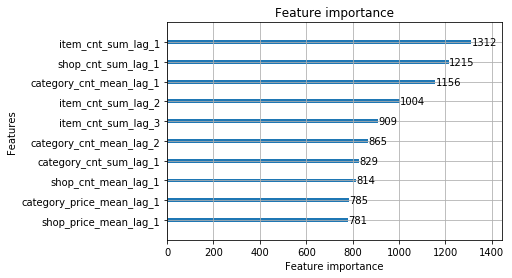

In [157]:
print('Plotting feature importances...')
ax = lgbm.plot_importance(model_lgb, max_num_features=10)
plt.show()

In [191]:
best_features_indices = np.argsort(model_lgb.feature_importance())[::-1][0:5]
lgbm_features[best_features_indices]

Index(['item_cnt_sum_lag_2', 'category_price_mean_lag_1',
       'category_cnt_mean_lag_1', 'category_cnt_sum_lag_1',
       'shop_price_mean_lag_1'],
      dtype='object')

In [38]:
test_w_cat_ids = test.set_index('item_id').join(items.set_index('item_id'))
test_w_cat_ids['date_block_num'] = 34

In [39]:
gc.collect()
def lagged_name(lag_column, lag):
    return "%s_lag_%d" % (lag_column, lag)

merge_columns = ['lagged_block','item_id','shop_id']

for lag in lags:
    print(lag)
    lagged = transactions.copy()
    lagged.rename(columns={'date_block_num':'lagged_block'},inplace=True)
    test_w_cat_ids['lagged_block'] = test_w_cat_ids['date_block_num'] - lag
    lagged_names = [lagged_name(c,lag) for c in lag_columns]
    lag_mapping = dict(zip(lag_columns, lagged_names))
    lagged.rename(columns=lag_mapping,inplace=True)
    test_w_cat_ids = pd.merge(test_w_cat_ids,lagged[lagged_names+merge_columns],on=merge_columns,how='left')
    del lagged
    gc.collect()

1
2
3
6
12


In [40]:
test_w_cat_ids.fillna(0, inplace=True)

In [41]:
test_w_cat_ids.head()

ID  item_id  shop_id                   item_name  item_category_id  \
0   2587       30        5  007: КООРДИНАТЫ «СКАЙФОЛЛ»                40   
1   7687       30        4  007: КООРДИНАТЫ «СКАЙФОЛЛ»                40   
2  12787       30        6  007: КООРДИНАТЫ «СКАЙФОЛЛ»                40   
3  17887       30        3  007: КООРДИНАТЫ «СКАЙФОЛЛ»                40   
4  22987       30        2  007: КООРДИНАТЫ «СКАЙФОЛЛ»                40   

   date_block_num  lagged_block  y_lag_1  item_cnt_sum_lag_1  \
0              34            22      0.0                 0.0   
1              34            22      0.0                 0.0   
2              34            22      0.0                 0.0   
3              34            22      0.0                 0.0   
4              34            22      0.0                 0.0   

   item_cnt_mean_lag_1             ...              y_lag_12  \
0                  0.0             ...                   0.0   
1                  0.0             ...                   0.0   
2                  0.0             ...                   1.0   
3                  0.0             ...                   0.0   
4                  0.0             ...                   0.0   

   item_cnt_sum_lag_12  item_cnt_mean_lag_12  item_price_mean_lag_12  \
0                  0.0                   0.0                     0.0   
1                  0.0                   0.0                     0.0   
2                 13.0                   1.0                   169.0   
3                  0.0                   0.0                     0.0   
4                  0.0                   0.0                     0.0   

   shop_cnt_sum_lag_12  shop_cnt_mean_lag_12  shop_price_mean_lag_12  \
0                  0.0              0.000000                 0.00000   
1                  0.0              0.000000                 0.00000   
2               3150.0              1.379159              1262.87496   
3                  0.0              0.000000                 0.00000   
4                  0.0              0.000000                 0.00000   

   category_cnt_sum_lag_12  category_cnt_mean_lag_12  \
0                      0.0                    0.0000   
1                      0.0                    0.0000   
2                  14815.0                    1.0903   
3                      0.0                    0.0000   
4                      0.0                    0.0000   

   category_price_mean_lag_12  
0                    0.000000  
1                    0.000000  
2                  264.032958  
3                    0.000000  
4                    0.000000  

[5 rows x 57 columns]

In [153]:
len(test_w_cat_ids)

214200

In [171]:
preds = model_lgb.predict(test_w_cat_ids[lgbm_features])
preds.clip(0,20,out=preds)

array([0.10561019, 0.10561019, 0.10561019, ..., 0.10561019, 0.10561019,
       0.10561019])

In [42]:
preds = cb_model.predict(test_w_cat_ids[lgbm_features])
preds.clip(0,20,out=preds)

array([0.20940502, 0.0825936 , 0.2155136 , ..., 0.0825936 , 0.25034494,
       0.0825936 ])

In [43]:
np.sum(preds)

54904.56302995094

In [44]:
submission = test.loc[:,['ID']]
submission['item_cnt_month'] = preds.astype(int)
#submission['item_cnt_month'] = ensemble_preds.astype(int)


submission.to_csv('submission.csv', index=False)